In [300]:
import numpy as np
import scipy as sc
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import tqdm
from numba import jit

from scipy.stats import ks_2samp as ks2
from scipy.stats import mannwhitneyu as mwu
from scipy.stats import kruskal
from scipy.stats import wasserstein_distance as w1_dist
from scipy.stats import energy_distance as w2_dist
from scipy.stats import epps_singleton_2samp as epps
from category_encoders import *

import SimpSOM as sps
import minisom as msom
#import sompy
from umap import UMAP
from sklearn.manifold import TSNE

import random

import os
import sys
from collections import Counter
from collections import namedtuple
from collections import defaultdict
import inspect
import itertools

from sklearn.ensemble import IsolationForest, RandomForestClassifier, VotingClassifier, BaggingClassifier
from sklearn.svm import OneClassSVM, NuSVC
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.linear_model import HuberRegressor, RANSACRegressor, BayesianRidge, LogisticRegression
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor, ExtraTreesRegressor
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA, NMF
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, SimpleImputer, IterativeImputer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.cross_decomposition import PLSRegression as PLS
from ngboost import NGBRegressor

from sklearn.cluster import SpectralClustering, AffinityPropagation, OPTICS, AgglomerativeClustering
#from hdbscan import HDBSCAN


In [301]:
def get_var_cols(d):
    assert isinstance(d, dict), 'input variables is not a dictionary'
    return list(itertools.chain.from_iterable(d.values()))

Data transformation:
* standard scaling
* robust scaler 

Feature reduction:
* minimum univariate distribution difference
* PCA 
* UMAP

Clustering method:
* HDBSCAN
* Spectral
* SOM

This analysis should provide us with an intuition of the separability of the targets 
with the given features.

**Output**: clusters can be used as features. 

In [302]:
os.chdir("T:\laupodteam\AIOS\Bram")
HS = pd.read_csv("data/HeartScore/Data/MATRIX_FULL_23jul2019_ECG.csv", sep=";")
index_cols = ['pathos_key', 'upod_id'] 
date_cols = ['AcquisitionDateTime_ECG'] 
meta_cols = ['setsrc', 'Analyzer']
pheno_cols = ['AGE', 'gender', 'BMI', 'RF_Diab', 'RF_Smok', 'RF_HyperTens', 'RF_HyperChol', 'RF_CVDHist', 'RF_FamHist', 'RF_obese30']
ign_cols = ['HS_AGE', 'HS_History', 'HS_ECG', 'HS_RiskFacts', 'HS_new2', 'tn_slope2', 'HN_TN'] # remove
tn_cols = ['tn_admission'] # moreve tn_slope2 and HN_TN

rem_cols = ['Door']+['delay_Celldyn', 'HS_new']+date_cols+meta_cols
HS.drop(rem_cols, axis=1, inplace=True)


# convert bool in int64
for _col in HS.columns.tolist():
    if str(HS[_col].dtype)=='bool':
        HS[_col] = HS[_col].astype(int)
        
target = 'casecontrol'
HS.rename(index=str, columns={target: 'target'}, inplace=True)
tmap = {'Control': 0, 'NSTEMI': 1}
HS['target'] = HS.target.map(tmap)
#HS.drop(target, axis=1, inplace=True)

gmap = {'M': 0, 'F': 1}
HS['gender'] = HS.gender.map(gmap)

HS.set_index(index_cols, inplace=True)

cols = HS.columns.tolist()
var_cols = list(set(cols) - set(meta_cols) - set(index_cols) -set(date_cols) - set(['target']) - set(ign_cols))

cell_dyn_cols = ["c_b_wbc","c_b_wvf","c_b_neu","c_b_seg","c_b_bnd","c_b_ig","c_b_lym","c_b_lyme","c_b_vlym","c_b_mon","c_b_mone","c_b_blst",
                 "c_b_eos","c_b_bas","c_b_pneu","c_b_pseg","c_b_pbnd","c_b_pig","c_b_plym","c_b_plyme","c_b_pvlym","c_b_pmon","c_b_pmone",
                 "c_b_pblst","c_b_peos","c_b_pbas","c_b_namn","c_b_nacv","c_b_nimn","c_b_nicv","c_b_npmn","c_b_npcv","c_b_ndmn",
                 "c_b_ndcv","c_b_nfmn","c_b_nfcv","c_b_Lamn","c_b_Lacv","c_b_Limn","c_b_Licv"] # delay_Celldyn: remove
ecg_cols_agg =  ["VentricularRate_ECG","AtrialRate_ECG","P_RInterval_ECG","QRS_Duration_ECG","Q_TInterval_ECG",
                 "QTCCalculation_ECG","PAxis_ECG","RAxis_ECG","TAxis_ECG","QRSCount_ECG","QOnset_ECG",
                 "QOffset_ECG","POnset_ECG","POffset_ECG","T_Onset_ECG","T_Offset_ECG","QRS_Onset_ECG",
                 "QRS_Offset_ECG","AvgRRInterval_ECG","QTcFredericia_ECG","QTcFramingham_ECG","QTc_Bazett_ECG"]

ecg_leads = ['Lead_I_', 'Lead_II_', 'Lead_III_', 'Lead_V1_', 'Lead_V2_', 'Lead_V3_', 'Lead_V4_', 'Lead_V5_', 'Lead_V6_', 'Lead_aVF_', 'Lead_aVL_', 'Lead_aVR_']
ecg_msrmnt = ['MaxST_ECG',  'Max_R_Ampl_ECG', 'Max_S_Ampl_ECG', 'MinST_ECG', 'PFull_Area_ECG', 'PP_Area_ECG', 'PP_Duration_ECG',
 'PP_PeakAmpl_ECG', 'PP_PeakTime_ECG', 'P_Area_ECG', 'P_Duration_ECG', 'P_PeakAmpl_ECG', 'P_PeakTime_ECG', 'QRS_Area_ECG', 'QRS_Balance_ECG',
 'QRS_Deflection_ECG', 'QRSint_ECG', 'Q_Area_ECG', 'Q_Duration_ECG', 'Q_PeakAmpl_ECG', 'Q_PeakTime_ECG', 'RP_Area_ECG', 'RP_Duration_ECG', 'RP_PeakAmpl_ECG',
 'RP_PeakTime_ECG', 'R_Area_ECG', 'R_Duration_ECG', 'R_PeakAmpl_ECG', 'R_PeakTime_ECG', 'SP_Area_ECG', 'SP_Duration_ECG', 'SP_PeakAmpl_ECG', 
 'SP_PeakTime_ECG', 'STE_ECG', 'STJ_ECG', 'STM_ECG', 'S_Area_ECG', 'S_Duration_ECG', 'S_PeakAmpl_ECG', 'S_PeakTime_ECG',
 'TFull_Area_ECG', 'TP_Area_ECG', 'TP_Duration_ECG', 'TP_PeakAmpl_ECG', 'TP_PeakTime_ECG', 'T_Area_ECG', 'T_Duration_ECG', 'T_End_ECG',
 'T_PeakAmpl_ECG', 'T_PeakTime_ECG', 'T_Special_ECG', 'P_OnsetAmpl_ECG']


ecg_cols_dyn = [_lead+_msrmnt for _lead in ecg_leads for _msrmnt in ecg_msrmnt]

ecg_cols_agg = list(set(ecg_cols_agg) & set(var_cols))
ecg_cols_dyn = list(set(ecg_cols_dyn) & set(var_cols))
cell_dyn_cols = list(set(cell_dyn_cols) & set(var_cols))

ecg_cols = list(set(ecg_cols_agg+ecg_cols_dyn))
other_cols = list(set(var_cols)-set(ecg_cols)-set(cell_dyn_cols))

col_dict = {'ecg': ecg_cols, 'celldyn': cell_dyn_cols, 'other': other_cols}
print("ECG: {} cols, \t CELLDYN: {} cols".format(len(ecg_cols), len(cell_dyn_cols)))

ECG: 646 cols, 	 CELLDYN: 40 cols


In [303]:
scaler= {'ecg': MinMaxScaler(), 'celldyn': MinMaxScaler(), 'other': MinMaxScaler()} # StandardScaler(), MinMaxScaler(), RobustScaler() or None
dim_reduction = None # {'ecg': PCA(n_components=6), 'celldyn': PCA(n_components=20)} # dict with dimension reduction per data group, or one dim red for all, or None, methods: PCA, NMF, UMAP
# dict with column name and impute type: median, mean, remove, regressor, (nmf?), or None, or knnimputer, or iterative which uses a round-robin approach using BayesianRidge as the regressor
feature_expansion = ['celldyn']

feature_weights = 'glm' # glm, tree, gam
clustering = 'hdbscan' # hdbscan, SOM, spectral
remove_nan_patients = False
# NGBRegressor(), BayesianRidge(), MLPRegressor(hidden_layer_sizes=(70,70,30))
imputance = {'BMI': BayesianRidge(), 
             'P_RInterval_ECG': BayesianRidge(), 
             'POnset_ECG': BayesianRidge(), 
             'PAxis_ECG': BayesianRidge(), 
             'POffset_ECG': BayesianRidge()}
missing_dummy = True
variance_remove = True
remove_multicoll = False
remove_outlying_samples_from_train = True
remove_outlying_samples_from_test = False
remove_weak_univariates = True

# Categorical encoding

In [304]:
# https://github.com/scikit-learn-contrib/categorical-encoding
dummy_cols = ['HS_AGE', 'HS_History', 'HS_ECG', 'HS_new2', 'HS_RiskFacts', 'HN_TN']
HS[dummy_cols] = HS[dummy_cols].astype('category')
HS = pd.get_dummies(HS, prefix_sep={_dummy: "_dummy_" for _dummy in dummy_cols})
dummy_cols = [_col for _col in HS.columns if '_dummy_' in _col]

In [305]:
hs_cols = ['tn_admission', 'tn_slope2', 'tn_diff_abs', 'tn_diff_rel']+dummy_cols

In [306]:
HS.loc[HS['tn_admission']>4000, 'tn_admission'] = 4000
HS.loc[HS['tn_slope2']<-100, 'tn_slope2'] = 100

In [307]:
HS['tn_diff_abs'] = HS[['tn_admission', 'tn_slope2']].apply(lambda x: np.sign(x[0]*x[1])*np.log10(np.abs(x[0]*x[1])+0.01), axis=1)
HS['tn_diff_rel'] = HS[['tn_admission', 'tn_slope2']].apply(lambda x: x[1]/(x[0]+1), axis=1)

# Imputance

Do not impute, rather treat missingness as a feature

In [308]:
print("Num NaN columns : ECG {}\tCELLDYN {}\tOTHER {}".format((HS[ecg_cols].isna().sum(axis=0)>0).sum(),
                                                       (HS[cell_dyn_cols].isna().sum(axis=0)>0).sum(),
                                                       (HS[other_cols].isna().sum(axis=0)>0).sum()))
###
print("Num NaN samples : ECG {}\tCELLDYN {}\tOTHER {}\tALL {}".format((HS[ecg_cols].isna().sum(axis=1)>0).sum(),
                                                       (HS[cell_dyn_cols].isna().sum(axis=1)>0).sum(),
                                                       (HS[other_cols].isna().sum(axis=1)>0).sum(),
                                                       (HS.isna().sum(axis=1)>0).sum()))

Num NaN columns : ECG 4	CELLDYN 0	OTHER 1
Num NaN samples : ECG 75	CELLDYN 0	OTHER 64	ALL 135


In [309]:
if remove_nan_patients:
    nan_patients = HS[var_cols].isna().sum(axis=1)[HS[var_cols].isna().sum(axis=1)>0].index
    HS.drop(index=nan_patients, inplace=True)
    print("Num NaN samples : ECG {}\tCELLDYN {}\tOTHER {}".format((HS[ecg_cols].isna().sum(axis=1)>0).sum(),
                                                       (HS[cell_dyn_cols].isna().sum(axis=1)>0).sum(),
                                                       (HS[other_cols].isna().sum(axis=1)>0).sum()))
    
    print("Num NaN columns : ECG {}\tCELLDYN {}\tOTHER {}".format((HS[ecg_cols].isna().sum(axis=0)>0).sum(),
                                                           (HS[cell_dyn_cols].isna().sum(axis=0)>0).sum(),
                                                           (HS[other_cols].isna().sum(axis=0)>0).sum()))   

    # y = HS[['target']]

In [310]:
# imputance

# consider adding Gaussian noise on top of the prediction
# https://www.kaggle.com/shashankasubrahmanya/missing-data-imputation-using-regression

if missing_dummy:
    # for NaN cols, treat non-nan as 0, nan as 1
    _c = HS[var_cols].columns
    nan_cols = _c[(HS[var_cols].isna().sum()>0)==True].tolist()    
    dummy_list = []
    for _ncol in nan_cols:
        dummy_name = 'availdummy_'+_ncol
        dummy_list.append(dummy_name)
        HS[dummy_name] = (~pd.isna(HS[_ncol])).astype(int)
        var_cols.append(dummy_name)
        dummy_comb = "_".join(dummy_list)
        HS[dummy_comb] = HS[dummy_list].apply(lambda x: np.product(x), axis=1)
        col_dict['other'] = col_dict['other'] + [dummy_name, dummy_comb]
    
if HS[var_cols].isna().sum().sum()>0:
    nan_cols = list(HS[var_cols].isna().sum()[HS[var_cols].isna().sum()>0].index)
    dat = HS.copy()
    if imputance is not None:
        if isinstance(imputance, dict):
            for _imp_key, _imp_val in imputance.items():
                if type(_imp_val)==str:
                    if _imp_val == 'median': 
                        dat.loc[dat[_imp_key].isna(), _imp_key] = np.nanmedian(dat[_imp_key])
                    elif _imp_val == 'mean':
                        dat.loc[dat[_imp_key].isna(), _imp_key] = np.nanmean(dat[_imp_key])
                    elif _imp_val == 'remove':
                        dat = dat.dropna(subset=[_imp_key])
                elif 'sklearn' in str(type(_imp_val)):  
                    _sub_cols = list(set(var_cols)  - set(nan_cols))
                    _y = dat.loc[~dat[_imp_key].isna(), _imp_key]
                    _X_train = dat.loc[~dat[_imp_key].isna(), _sub_cols]
                    _X_test = dat.loc[dat[_imp_key].isna(), _sub_cols]
                    try:
                        dat.loc[dat[_imp_key].isna(), _imp_key] = _imp_val.fit(_X_train, _y).predict(_X_test)
                    except Exception as e:
                        print("Imputance failed for {}, shapes: {}, {}, {}".format(_imp_key, _X_train.shape, _y.shape, _X_test.shape))
                        if _X_test.shape[0]==0:
                            print("Hmm, you probably already ran the imputer, please reload the data...")
        else:
            if imputance=='iterative':
                imp = IterativeImputer(estimator=BayesianRidge(), max_iter=10)
            elif imputance=='knnimputer':
                imp= KNNImputer(n_neighbors=5)

            dat = pd.DataFrame(data=imp.fit_transform(dat[var_cols]), index=HS.index, columns=var_cols)
            dat = dat.join(dat[meta_cols])
else:
    dat = HS

# Feature combiner

By default 
* CELLDYN: $\frac{A}{A+B+\epsilon}$, $\sqrt{A\cdot B}$ -> +800 features
* ECG: None
* OTHER: $\frac{A}{A+B+\epsilon}$, $\sqrt{A\cdot B}$ -> +600 features

In [311]:
@jit
def _ssqrt(x, y):
    return np.sqrt(np.multiply(x, y))
@jit
def _divisor(x, y, eps=1e-3):    
    return np.divide((x), (x+y+eps))
@jit
def expander2(x, fun=None):
    '''
        x : np array 
        fun : expansion function, assumes pairwise expansion
    '''
    num_rows, num_cols = x.shape[0], x.shape[1]
    _num_cols = np.int((num_cols**2-num_cols)/2)
    xex = np.zeros(shape=(num_rows, _num_cols)) 
    k=0
    for jl in range(0, num_cols):
        for jr in range(jl+1, num_cols):
            k +=1
            xex[:, k] =   fun(x[:,jl], x[:,jr])
    return xex

def _cols_(cols, prefix=None):
    prefix = prefix+"_" if prefix is not None else ""
    return [prefix+cols[jl]+"_"+cols[jr] for jl in range(0, len(cols)) for jr in range(jl+1, len(cols))]

var_cols = get_var_cols(col_dict)
for _key in feature_expansion:
    _cols = col_dict[_key]
    dat[_cols] = dat[_cols].astype(np.float64)
    tcols_sqrt = _cols_(dat[_cols].columns.tolist(), prefix='SQRT') 
    t = expander2(dat[_cols].values, fun=_ssqrt)
    celldyn_sqrt = pd.DataFrame(data=t, index=dat.index, columns=tcols_sqrt)

    tcols_div = _cols_(dat[_cols].columns.tolist(), prefix='DIV') 
    t = expander2(dat[_cols].values, fun=_divisor)
    celldyn_div = pd.DataFrame(data=t, index=dat.index, columns=tcols_div)

    col_dict[_key] = list(set(_cols + tcols_sqrt +tcols_div))
    var_cols = list(set(var_cols + col_dict[_key]))
    
    dat = dat.join(celldyn_sqrt)
    dat = dat.join(celldyn_div)

In [312]:
#cd = defaultdict(int)
#for _col in dat[col_dict['other']].columns.tolist():
#    cd[_col] += 1
#for k, v in cd.items():
#    if v>1:
#        print(k)

# Dimension reduction

In [313]:
def _condition_number(x, ignore_nan=True):
    return np.linalg.cond(x.dropna(), p=2)

print("PRE: Condition numbers:\n\t\t ECG {}, \t CELLDYN {}, \t Other {}".format(_condition_number(dat[col_dict['ecg']]), 
                                                                        _condition_number(dat[col_dict['celldyn']]),
                                                                        _condition_number(dat[col_dict['other']])))

PRE: Condition numbers:
		 ECG 2.89356949262352e+18, 	 CELLDYN 7.775543351134237e+18, 	 Other 8.090815806287678e+20


## Scaling

In [314]:
# Scaling 
# if not embedding..
if scaler is not None:
    if isinstance(scaler, dict):        
        for _imp_key, _scaler in scaler.items():
            if _scaler is not None:
                dat[col_dict[_imp_key]] = _scaler.fit_transform(dat[col_dict[_imp_key]]) 
    else:    
        dat[var_cols] = pd.DataFrame(data=scaler.fit_transform(dat[var_cols]), index=HS.index, columns=var_cols)


### Relative variance

Removing 10 columns due to lack of variance
POST: Condition numbers:
		 ECG 8.663696933729115e+17, 	 CELLDYN 6.900713162414634e+17, 	 Other 2.9780821722695188e+16


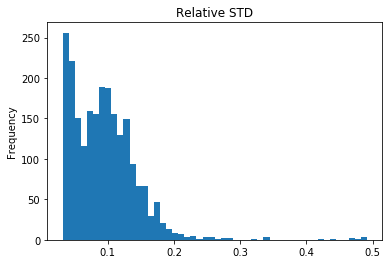

In [315]:
if variance_remove:
    def remove_min_variance(x, threshold=0.001):
        cols_to_keep = (x.var()/(x.max()-x.min()))\
            [((x.var()/(x.max()-x.min()))>threshold)].index   
        drop_cols = list(set(x.columns)-set(cols_to_keep))
        return x[cols_to_keep], drop_cols

    tmp_keep, drop_cols = remove_min_variance(dat[var_cols], threshold=0.001)
    print("Removing {} columns due to lack of variance".format(dat[var_cols].shape[1] - tmp_keep.shape[1]))

    col_dict['ecg'] = set(col_dict['ecg']).difference(set(drop_cols))
    col_dict['celldyn'] = set(col_dict['celldyn']).difference(set(drop_cols))
    col_dict['other'] = set(col_dict['other']).difference(set(drop_cols))
    var_cols = set(var_cols).difference(set(drop_cols))


    (tmp_keep.std()/(tmp_keep.max() - tmp_keep.min())).plot.hist(bins=50)
    plt.title('Relative STD')

    col_dict = {'ecg': list(col_dict['ecg']), 'celldyn': list(col_dict['celldyn']), 'other': list(col_dict['other'])}

    print("POST: Condition numbers:\n\t\t ECG {}, \t CELLDYN {}, \t Other {}".format(_condition_number(dat[col_dict['ecg']]), 
                                                                            _condition_number(dat[col_dict['celldyn']]),
                                                                            _condition_number(dat[col_dict['other']])))

We also want to deal with the very large variance features as they may contain little information, yet 

In [316]:
large_variance_features = dat[var_cols].columns[dat[var_cols].std()>0.3]

To remove low-variant features is actually to remove low entropy features. As the idea of low variance is completely dependent on the scaling of the feature low entropy will give a 
more robust feature filter. For continuous variables we have to use *differential entropy*, described as; 
$$H = - \int \rho(x) \ln \rho(x) dx $$

The best we can do is to approximate this using the histograms of the features;

$$H \approx - \sum \rho(b_i) \ln \rho(b_i) \Delta x_i$$

where $b_i$ represent the bins. To bound it between zero and one we should write

$$H \approx - \frac{\sum \rho(b_i) \ln \rho(b_i) \Delta x_i}{\sum \Delta x_i}$$

Note that the correct differential entropy is actually written as 
$$H = - \int \rho(x) \ln \frac{\rho(x)}{m(x)} dx $$

where $m(x)$ is the invariant measure.

In [317]:
@jit
def _diff_entropy(x, eps=1e-6, bins=10):
    rhos, xs = np.histogram(x, density=True, bins=bins)
    xmean =  (xs[1:] + xs[:-1])/2
    xdiff = xs[1:] - xs[:-1]
    H = -np.sum(rhos*np.log(rhos+eps)*xdiff)
    Hr = H/np.sum(xdiff)
    return Hr

In [318]:
var_cols = get_var_cols(col_dict)
feat_entropy = pd.DataFrame(data=dat[var_cols].apply(func=_diff_entropy, axis=0).apply(pd.Series))
feat_entropy.columns = ['Hr']

<ipython-input-317-1aa5c1f82215>:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "_diff_entropy" failed type inference due to: non-precise type pyobject
[1] During: typing of argument at <ipython-input-317-1aa5c1f82215> (3)

File "<ipython-input-317-1aa5c1f82215>", line 3:
def _diff_entropy(x, eps=1e-6, bins=10):
    rhos, xs = np.histogram(x, density=True, bins=bins)
    ^

  @jit
C:\Users\bes3\AppData\Roaming\Python\Python37\site-packages\numba\object_mode_passes.py:178: NumbaWarning: Function "_diff_entropy" was compiled in object mode without forceobj=True.

File "<ipython-input-317-1aa5c1f82215>", line 2:
@jit
def _diff_entropy(x, eps=1e-6, bins=10):
^

  state.func_ir.loc))
C:\Users\bes3\AppData\Roaming\Python\Python37\site-packages\numba\object_mode_passes.py:188: NumbaDeprecationWarning: 
Fall-back from the nopython compilation path to the object mode compilation path has been detected, this is deprecated behaviour.

For mo

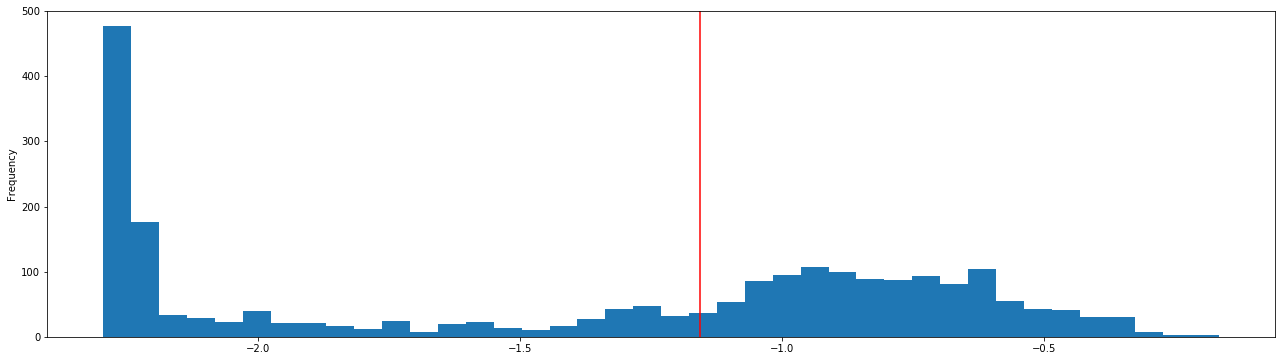

In [319]:
fig, ax = plt.subplots(figsize=(22,6))
feat_entropy.Hr.plot.hist(bins=40, ax=ax)
ax.axvline(feat_entropy.Hr.median(), color='red')

In [320]:
high_hr = feat_entropy.loc[(feat_entropy.Hr>-0.5)].index
low_hr = feat_entropy.loc[(feat_entropy.Hr<-2.15)].index
print(len(high_hr), len(low_hr))

133 681


Text(0.5, 1.0, 'low HR')

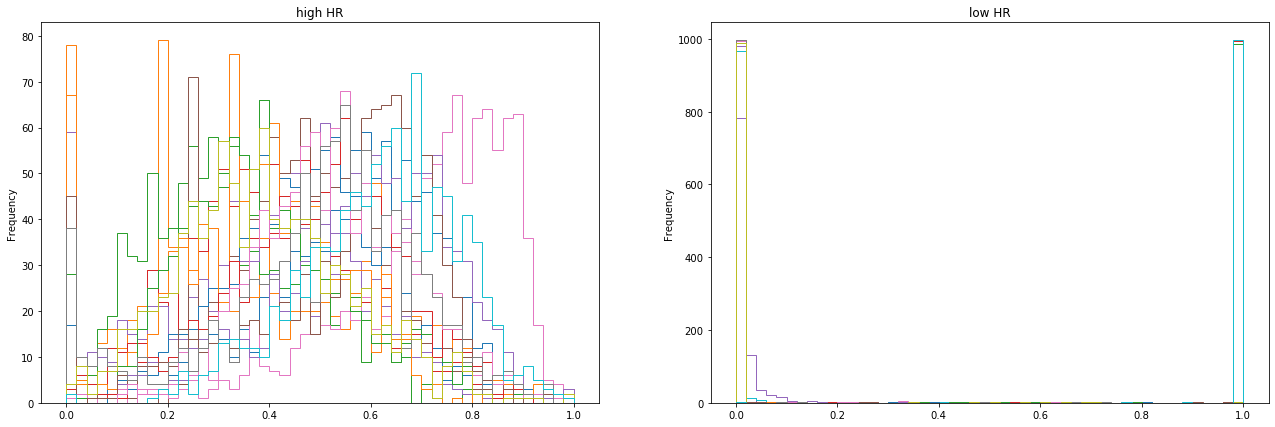

In [321]:
fig, ax = plt.subplots(ncols=2, figsize=(22,7))
n = 20 
N = len(high_hr)
for i in range(0, n):
    j = np.random.randint(0, N)
    dat[high_hr[j]].plot.hist(bins=50, histtype='step', ax=ax[0])
ax[0].set_title('high HR')
N = len(low_hr)    
for i in range(0, n):
    j = np.random.randint(0, N)
    dat[low_hr[j]].plot.hist(bins=50, histtype='step', ax=ax[1])
ax[1].set_title('low HR')


## feature selection
* ANOVA
* KS
* 1st and 2nd Wasserstein

In [322]:
class fs_ws1():
    scores_ = None
    def __init__(self, pvalue = 0.01):
        self.pvalue = pvalue

    def apply_test(self, pos, neg, column):
        zscore = w1_dist(pos[:,column], neg[:,column])
        return zscore
    
    def fit(self, x, y):
        zero_idx = np.where(y == 0)[0]
        one_idx = np.where(y == 1)[0]
        pos_samples = x[one_idx]
        neg_samples = x[zero_idx]                
        results_ = np.array(list(map(lambda c: 
            self.apply_test(pos_samples, neg_samples, c), range(0,x.shape[1]))))
        self.scores_ = results_
        return self
    
class fs_ws2():
    scores_ = None
    def __init__(self, pvalue = 0.01):
        self.pvalue = pvalue

    def apply_test(self, pos, neg, column):
        zscore = w2_dist(pos[:,column], neg[:,column])
        return zscore
    
    def fit(self, x, y):
        zero_idx = np.where(y == 0)[0]
        one_idx = np.where(y == 1)[0]
        pos_samples = x[one_idx]
        neg_samples = x[zero_idx]                
        results_ = np.array(list(map(lambda c: 
            self.apply_test(pos_samples, neg_samples, c), range(0,x.shape[1]))))
        self.scores_ = results_
        return self
    
class fs_mannwhitney():
    pvalues_ = None
    scores_ = None
    results_ = None
    def __init__(self, pvalue = 0.01, mode='auto'):
        # mode : 'auto', 'exact', 'asymp'
        self.pvalue = pvalue
        self.mode = mode

    def apply_test(self, pos, neg, column):
        zscore, p_value = mwu(pos[:,column], neg[:,column], alternative="less") # mode=self.mode
        return zscore, p_value
    
    def fit(self, x, y):
        zero_idx = np.where(y == 0)[0]
        one_idx = np.where(y == 1)[0]
        pos_samples = x[one_idx]
        neg_samples = x[zero_idx]                
        self.results_ = np.array(list(map(lambda c: 
            self.apply_test(pos_samples, neg_samples, c), range(0,x.shape[1]))))
        self.scores_ = self.results_[:, 0]
        self.pvalues_ = self.results_[:, 1]
        return self

    def transform(self, x):
        not_signif = self.p_values<self.pvalue
        to_delete = [idx for idx, item in enumerate(not_signif) if item == False]
        return np.delete(x, to_delete, axis = 1), to_delete

class fs_ks():
    pvalues_ = None
    scores_ = None
    results_ = None
    def __init__(self, pvalue = 0.01):
        self.pvalue = pvalue

    def apply_test(self, pos, neg, column):
        zscore, p_value = ks2(pos[:,column], neg[:,column])
        return zscore, p_value
    
    def fit(self, x, y):
        zero_idx = np.where(y == 0)[0]
        one_idx = np.where(y == 1)[0]
        pos_samples = x[one_idx]
        neg_samples = x[zero_idx]                
        self.results_ = np.array(list(map(lambda c: 
            self.apply_test(pos_samples, neg_samples, c), range(0,x.shape[1]))))
        self.scores_ = self.results_[:, 0]
        self.pvalues_ = self.results_[:, 1]
        return self

    def transform(self, x):
        not_signif = self.p_values<self.pvalue
        to_delete = [idx for idx, item in enumerate(not_signif) if item == False]
        return np.delete(x, to_delete, axis = 1), to_delete


class fs_epps():
    pvalues_ = None
    scores_ = None
    results_ = None
    def __init__(self, pvalue = 0.01):
        self.pvalue = pvalue

    def apply_test(self, pos, neg, column):
        zscore, p_value = epps(pos[:,column], neg[:,column])
        return zscore, p_value
    
    def fit(self, x, y):
        zero_idx = np.where(y == 0)[0]
        one_idx = np.where(y == 1)[0]
        pos_samples = x[one_idx]
        neg_samples = x[zero_idx]                
        self.results_ = np.array(list(map(lambda c: 
            self.apply_test(pos_samples, neg_samples, c), range(0,x.shape[1]))))
        self.scores_ = self.results_[:, 0]
        self.pvalues_ = self.results_[:, 1]
        return self

    def transform(self, x):
        not_signif = self.p_values<self.pvalue
        to_delete = [idx for idx, item in enumerate(not_signif) if item == False]
        return np.delete(x, to_delete, axis = 1), to_delete

In [323]:
from sklearn.feature_selection import f_classif, chi2, mutual_info_classif

y = dat['target']

if remove_weak_univariates:
    anov = dict()
    anov['celldyn'] = pd.DataFrame(data=f_classif(dat[col_dict['celldyn']], y), columns=col_dict['celldyn'], index=['F', 'pval']).T
    anov['ecg'] = pd.DataFrame(data=f_classif(dat[col_dict['ecg']], y), columns=col_dict['ecg'], index=['F', 'pval']).T
    anov['other'] = pd.DataFrame(data=f_classif(dat[col_dict['other']], y), columns=col_dict['other'], index=['F', 'pval']).T

    chisq = dict()
    chisq['celldyn'] = pd.DataFrame(data=chi2(dat[col_dict['celldyn']].abs(), y), columns=col_dict['celldyn'], index=['Chi', 'pval']).T
    chisq['ecg'] = pd.DataFrame(data=chi2(dat[col_dict['ecg']].abs(), y), columns=col_dict['ecg'], index=['Chi', 'pval']).T
    chisq['other'] = pd.DataFrame(data=chi2(dat[col_dict['other']].abs(), y), columns=col_dict['other'], index=['Chi', 'pval']).T

    mi = dict()
    mi['celldyn'] = pd.DataFrame(data=mutual_info_classif(dat[col_dict['celldyn']].abs(), y), index=col_dict['celldyn'], columns=['mi'])
    mi['ecg'] = pd.DataFrame(data=mutual_info_classif(dat[col_dict['ecg']].abs(), y), index=col_dict['ecg'], columns=['mi'])
    mi['other'] = pd.DataFrame(data=mutual_info_classif(dat[col_dict['other']].abs(), y), index=col_dict['other'], columns=['mi'])


    ks_dist = dict()
    KS = fs_ks()
    KS.fit(dat[col_dict['other']].values, y)
    ks_dist['other'] = pd.DataFrame(KS.results_, columns=['KS', 'pval'], index=col_dict['other'])

    KS.fit(dat[col_dict['celldyn']].values, y)
    ks_dist['celldyn'] = pd.DataFrame(KS.results_, columns=['KS', 'pval'], index=col_dict['celldyn'])

    KS.fit(dat[col_dict['ecg']].values, y)
    ks_dist['ecg'] = pd.DataFrame(KS.results_, columns=['KS', 'pval'], index=col_dict['ecg'])


    mwu_dist = dict()
    MW = fs_mannwhitney()
    MW.fit(dat[col_dict['other']].values, y)
    mwu_dist['other'] = pd.DataFrame(MW.results_, columns=['MWS', 'pval'], index=col_dict['other'])

    MW.fit(dat[col_dict['celldyn']].values, y)
    mwu_dist['celldyn'] = pd.DataFrame(MW.results_, columns=['MWS', 'pval'], index=col_dict['celldyn'])

    MW.fit(dat[col_dict['ecg']].values, y)
    mwu_dist['ecg'] = pd.DataFrame(MW.results_, columns=['MWS', 'pval'], index=col_dict['ecg'])

    mwu_dist['celldyn']['MWS'] = 4*(mwu_dist['celldyn']['MWS'])/(dat.shape[0]*(dat.shape[0]+1))
    mwu_dist['ecg']['MWS'] = 4*(mwu_dist['ecg']['MWS'])/(dat.shape[0]*(dat.shape[0]+1))
    mwu_dist['other']['MWS'] = 4*(mwu_dist['other']['MWS'])/(dat.shape[0]*(dat.shape[0]+1))


    try:
        epps_dist = dict()
        EPPS = fs_epps()
        EPPS.fit(dat[col_dict['other']].values, y)
        epps_dist['other'] = pd.DataFrame(EPPS.results_, columns=['EPPS', 'pval'], index=col_dict['other'])

        EPPS.fit(dat[col_dict['ecg']].values, y)
        epps_dist['ecg'] = pd.DataFrame(EPPS.results_, columns=['EPPS', 'pval'], index=col_dict['ecg'])

        EPPS.fit(dat[col_dict['celldyn']].values, y)
        epps_dist['celldyn'] = pd.DataFrame(EPPS.results_, columns=['EPPS', 'pval'], index=col_dict['celldyn'])
    except Exception as e:
        if str(e)=='SVD did not converge':
            print("!! \t Remove the multicollinearity of the input matrix \t!!")
        else:
            print("Oooeps: {}".format(e))

    # w1
    wass1_dist = dict()
    W1D = fs_ws1()
    W1D.fit(dat[col_dict['other']].values, y)
    wass1_dist['other'] = pd.DataFrame(W1D.scores_, columns=['W1'], index=col_dict['other'])

    W1D.fit(dat[col_dict['celldyn']].values, y)
    wass1_dist['celldyn'] = pd.DataFrame(W1D.scores_, columns=['W1'], index=col_dict['celldyn'])

    W1D.fit(dat[col_dict['ecg']].values, y)
    wass1_dist['ecg'] = pd.DataFrame(W1D.scores_, columns=['W1'], index=col_dict['ecg'])

    # w2
    wass2_dist = dict()
    W2D = fs_ws2()
    W2D.fit(dat[col_dict['other']].values, y)
    wass2_dist['other'] = pd.DataFrame(W2D.scores_, columns=['W2'], index=col_dict['other'])

    W2D.fit(dat[col_dict['celldyn']].values, y)
    wass2_dist['celldyn'] = pd.DataFrame(W2D.scores_, columns=['W2'], index=col_dict['celldyn'])

    W2D.fit(dat[col_dict['ecg']].values, y)
    wass2_dist['ecg'] = pd.DataFrame(W2D.scores_, columns=['W2'], index=col_dict['ecg'])

    ecg_inc_anova = anov['ecg'][anov['ecg'].F>5].index.tolist()
    celldyn_inc_anova = anov['celldyn'][anov['celldyn'].F>5].index.tolist()

    ecg_inc_mi = mi['ecg'][mi['ecg'].mi>0.003].index.tolist()
    celldyn_inc_mi = mi['celldyn'][mi['celldyn'].mi>0.003].index.tolist()

    col_dict['ecg'] = list(set(ecg_inc_anova+ecg_inc_mi))
    col_dict['celldyn'] = list(set(celldyn_inc_anova+celldyn_inc_mi))
    var_cols = get_var_cols(col_dict)

## Multi-collinearity

I.e. **the problem of removing all correlated pairs as efficiently as possible, meaning by removing a minimum number of nodes at the lowest computational cost.**

The efficient removal of multicollinearity can be cast in graph optimisation problem.

* Maximal Clique Enumeration (MCE): from all the maximal cliques, keep only the node with the lowest mean similarity. This is iterative; 
    * start with the largest cliques, exclude, redetermine cliques, exclude, etc. Until only pairs are left
    * Remove all nodes with occurrence > 1, then randomly remove nodes   
* Recursively remove 50% of the pairs until no pairs are left
* Instead of removing the collinear pairs multiply them. 

In [324]:
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from statsmodels.tools.tools import add_constant
from sklearn.metrics.pairwise import cosine_similarity as cosim
   
def coll_cols(x, threshold=0.99, how='corr_aff', ignore_nan=True):
    '''
     x : df
     threshold : maximum correlation or maximum VIF
     how : correlation (corr_aff, corr_pair) of VIF-based (vif)
    '''
    cols = x.columns.tolist()
    if ignore_nan:
        x=x.dropna() # x.fillna(x.median())   
    if how=='vif':
        cols_to_remove = []
        x = add_constant(x)
        x[cols] = StandardScaler().fit_transform(x[cols]) 
        vifs = []
        for idx, col in tqdm(enumerate(cols)):
            _vif = vif(x.values, idx)
            if _vif != np.inf:                
                vifs.append(_vif)
            if vif(x.values, idx)>threshold:
                cols_to_remove.append(col)
        vifs = np.array(vifs)
        print("VIF:\t max {}, \t min {}, \t mean {}, \t median {}".format(vifs.max(), vifs.min(), vifs.mean(), np.median(vifs)))
        plt.hist(np.log10(vifs), bins=50, density=True)
    elif how=='corr_aff':
        corrcoefs = x.corr().values  # np.corrcoef(tmp[var_cols]) , tmp[var_cols].corr().values         

        AF = AffinityPropagation(damping=0.65, max_iter=200, convergence_iter=50, preference=None, affinity='precomputed')
        labels = AF.fit_predict(-1/corrcoefs**2)
        exemplars = AF.cluster_centers_indices_
        cols_to_remove = [var_cols[i] for i in exemplars]
    elif how=='corr_pair':
        # simplistic 
        corrcoefs = cosim(np.transpose(x)) # cosim(x) # x.corr().values # np.abs(np.corrcoef(x, rowvar=False)), cosim(x)
        print(corrcoefs.shape, x.shape)
        conn_count = { k: 0 for k in cols}
        conn_nodes = defaultdict(list)
        for idx, _colx in enumerate(cols):
            for jdx, _coly in enumerate(cols):
                if jdx<idx:
                    if corrcoefs[idx, jdx]>threshold:
                        conn_count[_colx]  += 1
                        conn_count[_coly]  += 1
                        conn_nodes[_colx]  += [_coly]
                        conn_nodes[_coly]  += [_colx]         
        cols_to_remove = [_v[0] for _v in conn_nodes.values()]
        
    print("{} columns should be removed due to collinearity.".format(len(cols_to_remove)))  
    return cols_to_remove
if remove_multicoll:
    drop_cols = coll_cols(dat[col_dict['ecg']], how='corr_pair', threshold=0.98, ignore_nan=False)
    col_dict['ecg'] = list(set(col_dict['ecg']).difference(set(drop_cols)))

    drop_cols = coll_cols(dat[col_dict['celldyn']], how='corr_pair', threshold=0.98, ignore_nan=False)
    col_dict['celldyn'] = list(set(col_dict['celldyn']).difference(set(drop_cols)))

    #drop_cols = coll_cols(dat[col_dict['other']], how='vif', threshold=0.98, ignore_nan=False)
    #col_dict['other'] = list(set(col_dict['other']).difference(set(drop_cols)))

    #var_cols = list(set(var_cols).difference(set(drop_cols)))

    print("POST: Condition numbers:\n\t\t ECG {}, \t CELLDYN {}, \t Other {}".format(_condition_number(dat[col_dict['ecg']]), 
                                                                            _condition_number(dat[col_dict['celldyn']]),
                                                                            _condition_number(dat[col_dict['other']])))

## embedding
* PCA
* UMAP
* NMF

In [325]:
# Dim reduction
if dim_reduction is not None:
    if isinstance(dim_reduction, dict):
        assert(set(dim_reduction.keys()).issubset(['ecg', 'celldyn'])), "Check the dim_reduction keys"
        ecols = ['ecg_'+str(i) for i in range(0, dim_reduction['ecg'].n_components)]
        ecg_red = pd.DataFrame(dim_reduction['ecg'].fit_transform(dat[ecg_cols]), index=dat.index, columns=ecols)
        ccols = ['celldyn_'+str(i) for i in range(0, dim_reduction['celldyn'].n_components)]
        celldyn_red = pd.DataFrame(dim_reduction['celldyn'].fit_transform(dat[cell_dyn_cols]), index=dat.index, columns=ccols)
        
        dat_red = dat[other_cols].join(ecg_red).join(celldyn_red)
    else:
        rcols = ['red_'+str(i) for i in range(0, dim_reduction['ecg'].n_components)]
        tot_red = pd.DataFrame(dim_reduction.fit_transform(dat[var_cols]), index=dat.index, columns=rcols)
        dat_red = dat[other_cols].join(tot_red)

## Outliers

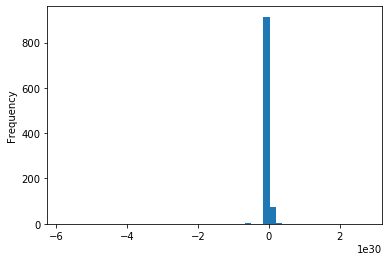

In [326]:
# Mahalanobis distance for outliers
def mahalanobis(x=None, cov=None):
    # source: https://www.machinelearningplus.com/statistics/mahalanobis-distance/
    """Compute the Mahalanobis Distance between each row of x and the data  
    x    : vector or matrix of data with, say, p columns.
    data : ndarray of the distribution from which Mahalanobis distance of each observation of x is to be computed.
    cov  : covariance matrix (p x p) of the distribution. If None, will be computed from data.
    """
    x_minus_mu = x - np.mean(x)
    if not cov:
        cov = np.cov(x.values.T)
    inv_covmat = sc.linalg.inv(cov)
    left_term = np.dot(x_minus_mu, inv_covmat)
    mahal = np.dot(left_term, x_minus_mu.T)
    return mahal.diagonal()

var_cols = col_dict['ecg']+col_dict['celldyn']+col_dict['other']

out_idx_dict= {}

iso = IsolationForest(n_estimators=400, n_jobs=4)
out_in = iso.fit_predict(dat[var_cols])
out_idx_dict['iso'] = np.where(out_in==-1)
in_idx = np.where(out_in==1)

ocs = OneClassSVM(kernel='rbf', gamma='scale', max_iter=1000)
out_in = ocs.fit_predict(dat[var_cols])
out_idx_dict['svm'] = np.where(out_in==-1)
    
try:
    mah = mahalanobis(dat[var_cols])
    dat['_maha'] = mah
    # isolation forest
    dat._maha.plot.hist(bins=50)
except:
    print("matrix is singular..you did not remove the collinearity did you ;)")

In [327]:
if remove_outlying_samples_from_train:
    dat.drop(dat.index[out_idx_dict['iso'][0]], axis=0, inplace=True)

## Reduced dimensionality visualisation

### PCA

In [328]:
print("ECG: {} cols, \t CELLDYN: {} cols, \t OTHER:{} cols".format(len(col_dict['ecg']), len(col_dict['celldyn']), len(col_dict['other'])))

ECG: 644 cols, 	 CELLDYN: 1592 cols, 	 OTHER:20 cols


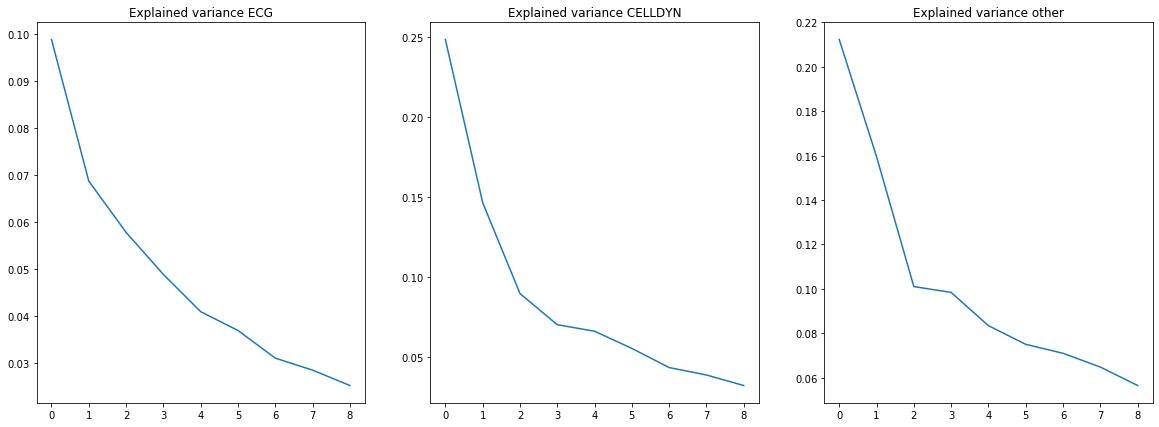

In [329]:
dat_viz={}
nc = 9
red_cols = ['pc_'+str(i) for i in range(0, nc)]
pc = {}
fig, ax = plt.subplots(ncols=3, figsize=(20,7))

pc['ecg'] = PCA(n_components=nc, svd_solver='full')
tred = pc['ecg'].fit_transform(dat[col_dict['ecg']])
ax[0].plot(pc['ecg'].explained_variance_ratio_)
ax[0].set_title('Explained variance ECG')
dat_viz['pca_celldyn']  = pd.DataFrame(data=tred, index=dat.index, columns=red_cols)

pc['celldyn'] = PCA(n_components=nc, svd_solver='full')
tred = pc['celldyn'].fit_transform(dat[col_dict['celldyn']])
ax[1].plot(pc['celldyn'].explained_variance_ratio_)
ax[1].set_title('Explained variance CELLDYN')
dat_viz['pca_ecg']  = pd.DataFrame(data=tred, index=dat.index, columns=red_cols)

pc['other'] = PCA(n_components=nc, svd_solver='full')
tred = pc['other'].fit_transform(dat[col_dict['other']])
ax[2].plot(pc['other'].explained_variance_ratio_)
ax[2].set_title('Explained variance other')
dat_viz['pca_other'] = pd.DataFrame(data=tred, index=dat.index, columns=red_cols)

The explained variance of the first component is huge, this suggests that there is a leaking feature.

Text(0.5, 1.0, 'other PC 2')

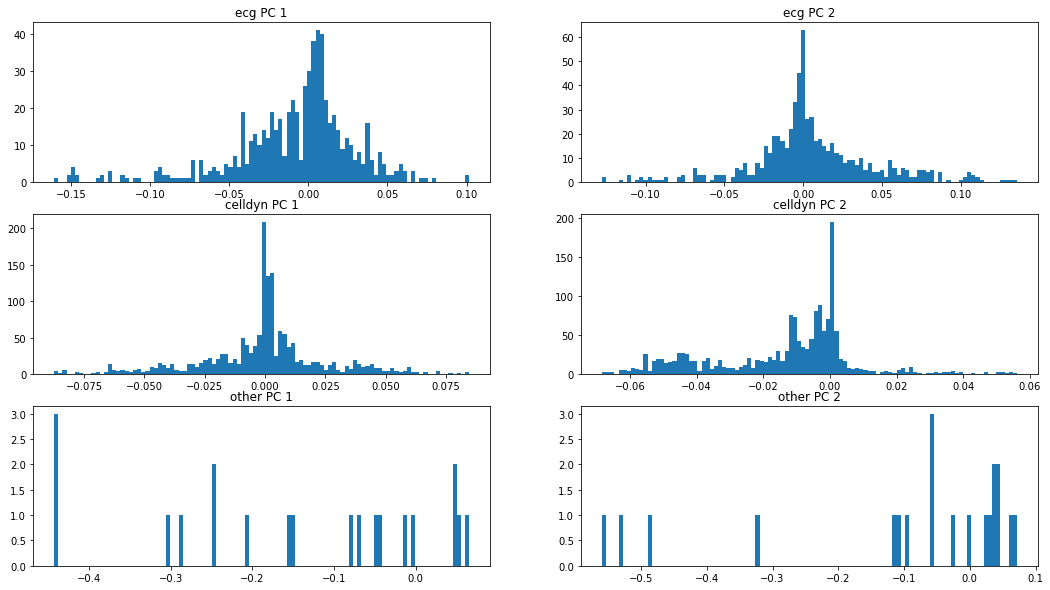

In [330]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(18,10))
ax[0,0].hist(pc['ecg'].components_[0], bins=100); ax[0,0].set_title('ecg PC 1')
ax[0,1].hist(pc['ecg'].components_[1], bins=100); ax[0,1].set_title('ecg PC 2')
ax[1,0].hist(pc['celldyn'].components_[0], bins=100); ax[1,0].set_title('celldyn PC 1')
ax[1,1].hist(pc['celldyn'].components_[1], bins=100); ax[1,1].set_title('celldyn PC 2')
ax[2,0].hist(pc['other'].components_[0], bins=100); ax[2,0].set_title('other PC 1')
ax[2,1].hist(pc['other'].components_[1], bins=100); ax[2,1].set_title('other PC 2')

Text(0.5, 1.0, 'PCA OTHER')

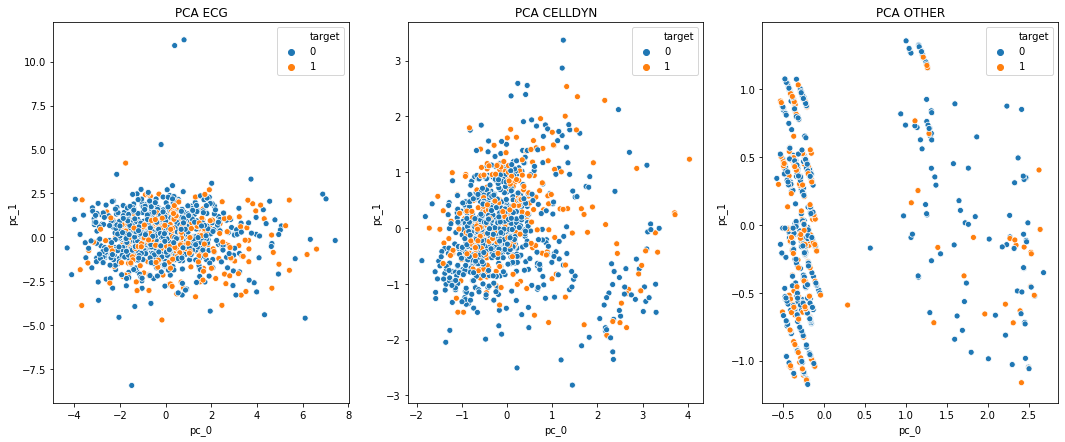

In [331]:
fig, ax = plt.subplots(ncols=3, figsize=(18,7))
sns.scatterplot(data=dat_viz['pca_ecg'], x='pc_0', y='pc_1', hue=y, ax=ax[0])
sns.scatterplot(data=dat_viz['pca_celldyn'], x='pc_0', y='pc_1', hue=y, ax=ax[1])
sns.scatterplot(data=dat_viz['pca_other'], x='pc_0', y='pc_1', hue=y, ax=ax[2])
ax[0].set_title('PCA ECG')
ax[1].set_title('PCA CELLDYN')
ax[2].set_title('PCA OTHER')

## NMF

In [332]:
nc = 20
red_cols = ['pc_'+str(i) for i in range(0, nc)]

nnmf = {}
nnmf['ecg'] = NMF(n_components=nc)
tred = nnmf['ecg'].fit_transform(dat[col_dict['ecg']]+dat[col_dict['ecg']].min().abs())
dat_viz['nmnf_ecg']  = pd.DataFrame(data=tred, index=dat.index, columns=red_cols)

nnmf['celldyn'] = NMF(n_components=nc)
tred = nnmf['celldyn'].fit_transform(dat[col_dict['celldyn']]+dat[col_dict['celldyn']].min().abs())
dat_viz['nmnf_celldyn']  = pd.DataFrame(data=tred, index=dat.index, columns=red_cols)

nnmf['other'] = NMF(n_components=nc)
tred = nnmf['other'].fit_transform(dat[col_dict['other']]+dat[col_dict['other']].min().abs())
dat_viz['nmnf_other']  = pd.DataFrame(data=tred, index=dat.index, columns=red_cols)

print("Reconstruction errors: ECG {}, \t CELLDYN {}, \t OTHER {}".format(nnmf['ecg'].reconstruction_err_, 
                                                                         nnmf['celldyn'].reconstruction_err_,
                                                                         nnmf['other'].reconstruction_err_))

Reconstruction errors: ECG 65.34021488156971, 	 CELLDYN 38.405813834281766, 	 OTHER 2.5221916491670564


Text(0.5, 1.0, 'NMF OTHER')

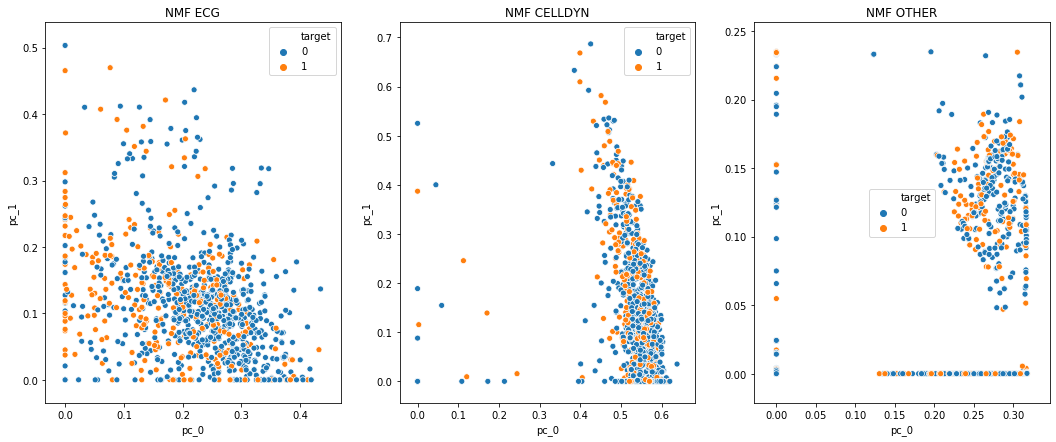

In [333]:
fig, ax = plt.subplots(ncols=3, figsize=(18,7))
sns.scatterplot(data=dat_viz['nmnf_ecg'], x='pc_0', y='pc_1', hue=y, ax=ax[0])
sns.scatterplot(data=dat_viz['nmnf_celldyn'], x='pc_0', y='pc_1', hue=y, ax=ax[1])
sns.scatterplot(data=dat_viz['nmnf_other'], x='pc_0', y='pc_1', hue=y, ax=ax[2])
ax[0].set_title('NMF ECG')
ax[1].set_title('NMF CELLDYN')
ax[2].set_title('NMF OTHER')

### UMAP

In [334]:
um_ecg = UMAP(n_components=2, n_neighbors=7, min_dist=0.01)
um_celldyn = UMAP(n_components=2, n_neighbors=7, min_dist=0.01)
um_other = UMAP(n_components=2, n_neighbors=7, min_dist=0.01)
um_all = UMAP(n_components=2, n_neighbors=7, min_dist=0.01)

tsne_ecg = TSNE(n_components=2, perplexity=50.0, early_exaggeration=12.0, learning_rate=200.0, n_iter=2000)
tsne_celldyn = TSNE(n_components=2, perplexity=50.0, early_exaggeration=12.0, learning_rate=200.0, n_iter=2000)
tsne_other = TSNE(n_components=2, perplexity=50.0, early_exaggeration=12.0, learning_rate=200.0, n_iter=2000)
tsne_all = TSNE(n_components=2, perplexity=50.0, early_exaggeration=12.0, learning_rate=200.0, n_iter=2000)

In [335]:
var_cols = [__val for _val in col_dict.values() for __val in _val]
dat_viz['umap_other'] =  pd.DataFrame(data=um_other.fit_transform(dat[col_dict['other']]), index=dat.index, columns=['pc_1', 'pc_2'])
dat_viz['umap_ecg'] = pd.DataFrame(data=um_ecg.fit_transform(dat[col_dict['ecg']]), index=dat.index, columns=['pc_1', 'pc_2'])
dat_viz['umap_celldyn'] = pd.DataFrame(data=um_celldyn.fit_transform(dat[col_dict['celldyn']]), index=dat.index, columns=['pc_1', 'pc_2'])
dat_viz['umap_all'] = pd.DataFrame(data=um_all.fit_transform(dat[var_cols]), index=dat.index, columns=['pc_1', 'pc_2'])

dat_viz['tsne_other'] =  pd.DataFrame(data=tsne_other.fit_transform(dat[col_dict['other']]), index=dat.index, columns=['pc_1', 'pc_2'])
dat_viz['tsne_ecg'] = pd.DataFrame(data=tsne_ecg.fit_transform(dat[col_dict['ecg']]), index=dat.index, columns=['pc_1', 'pc_2'])
dat_viz['tsne_celldyn'] = pd.DataFrame(data=tsne_celldyn.fit_transform(dat[col_dict['celldyn']]), index=dat.index, columns=['pc_1', 'pc_2'])
dat_viz['tsne_all'] = pd.DataFrame(data=tsne_all.fit_transform(dat[var_cols]), index=dat.index, columns=['pc_1', 'pc_2'])

c:\users\bes3\appdata\local\programs\python\python37\lib\site-packages\umap\spectral.py:229: UserWarning: Embedding a total of 3 separate connected components using meta-embedding (experimental)
  n_components


Text(0.5, 1.0, 'TSNE ALL')

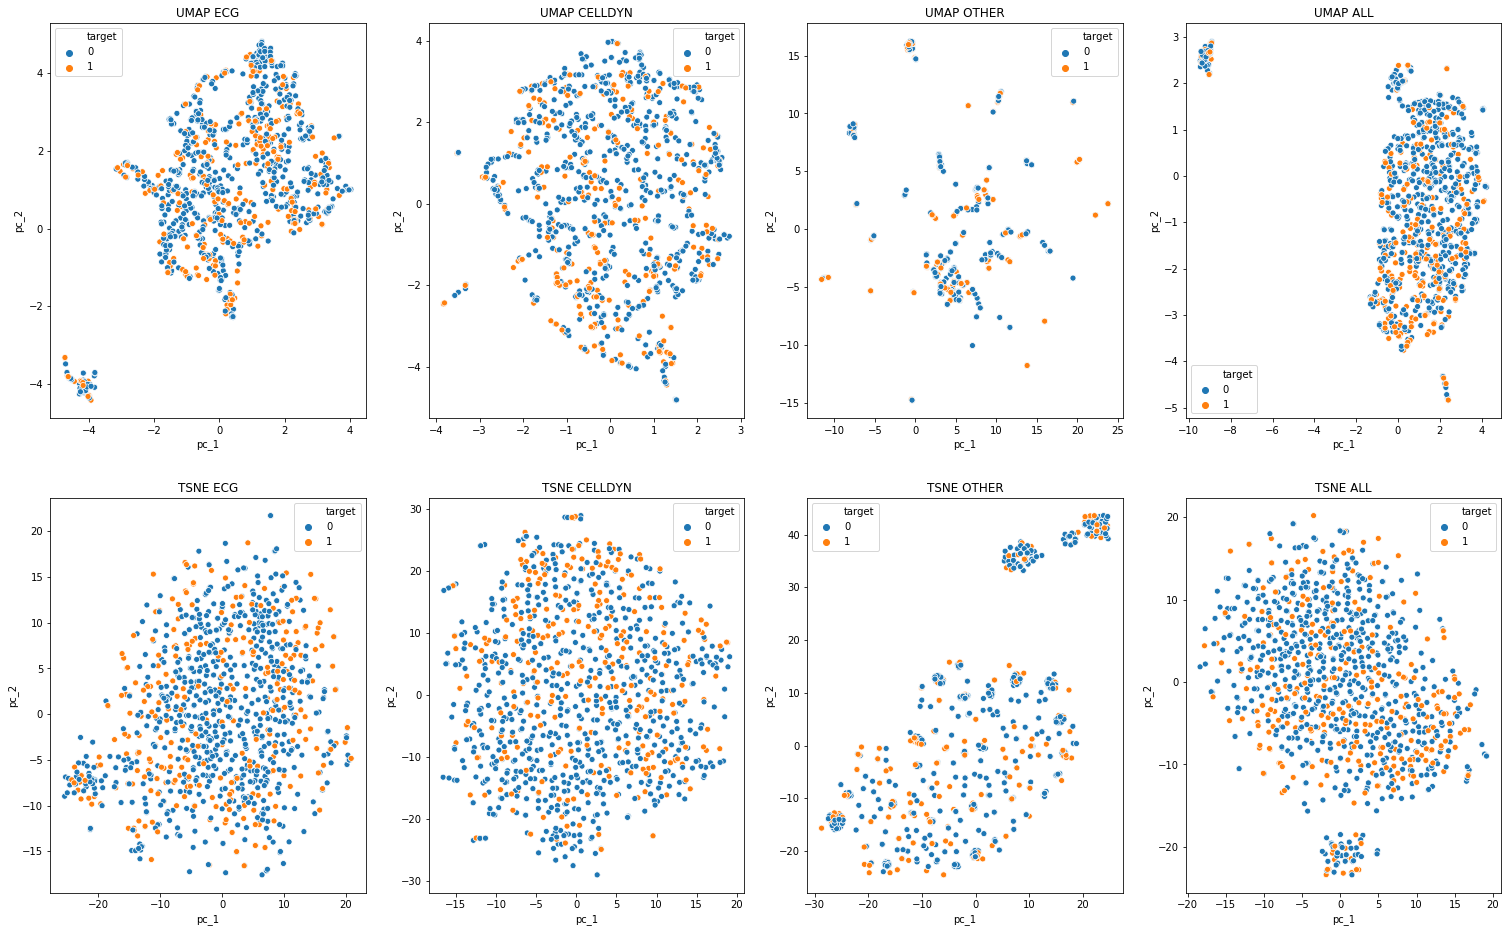

In [336]:
fig, ax = plt.subplots(ncols=4, nrows=2, figsize=(26,16))
sns.scatterplot(data=dat_viz['umap_ecg'], x='pc_1', y='pc_2', hue=y, ax=ax[0,0])
sns.scatterplot(data=dat_viz['umap_celldyn'], x='pc_1', y='pc_2', hue=y, ax=ax[0,1])
sns.scatterplot(data=dat_viz['umap_other'], x='pc_1', y='pc_2', hue=y, ax=ax[0,2])
sns.scatterplot(data=dat_viz['umap_all'], x='pc_1', y='pc_2', hue=y, ax=ax[0,3])
ax[0,0].set_title('UMAP ECG')
ax[0,1].set_title('UMAP CELLDYN')
ax[0,2].set_title('UMAP OTHER')
ax[0,3].set_title('UMAP ALL')

sns.scatterplot(data=dat_viz['tsne_ecg'], x='pc_1', y='pc_2', hue=y, ax=ax[1,0])
sns.scatterplot(data=dat_viz['tsne_celldyn'], x='pc_1', y='pc_2', hue=y, ax=ax[1,1])
sns.scatterplot(data=dat_viz['tsne_other'], x='pc_1', y='pc_2', hue=y, ax=ax[1,2])
sns.scatterplot(data=dat_viz['tsne_all'], x='pc_1', y='pc_2', hue=y, ax=ax[1,3])
ax[1,0].set_title('TSNE ECG')
ax[1,1].set_title('TSNE CELLDYN')
ax[1,2].set_title('TSNE OTHER')
ax[1,3].set_title('TSNE ALL')

# Supervised clustering

## UMAP

In [337]:
um_all_sup = UMAP(n_components=3, n_neighbors=10, min_dist=0.1)
dat_viz['umap_all_sup'] = pd.DataFrame(data=um_all_sup.fit_transform(dat[var_cols], 
                                                             y=y), 
                                   index=dat.index, columns=['pcu_1', 'pcu_2', 'pcu_3'])

um_ecg_sup = UMAP(n_components=3, n_neighbors=10, min_dist=0.1)
dat_viz['umap_ecg_sup'] = pd.DataFrame(data=um_ecg_sup.fit_transform(dat[var_cols], 
                                                             y=y), 
                                   index=dat.index, columns=['pcu_1', 'pcu_2', 'pcu_3'])

um_celldyn_sup = UMAP(n_components=3, n_neighbors=10, min_dist=0.1)
dat_viz['umap_celldyn_sup'] = pd.DataFrame(data=um_celldyn_sup.fit_transform(dat[var_cols], 
                                                             y=y), 
                                   index=dat.index, columns=['pcu_1', 'pcu_2', 'pcu_3'])

Text(0.5, 1.0, 'Celldyn features')

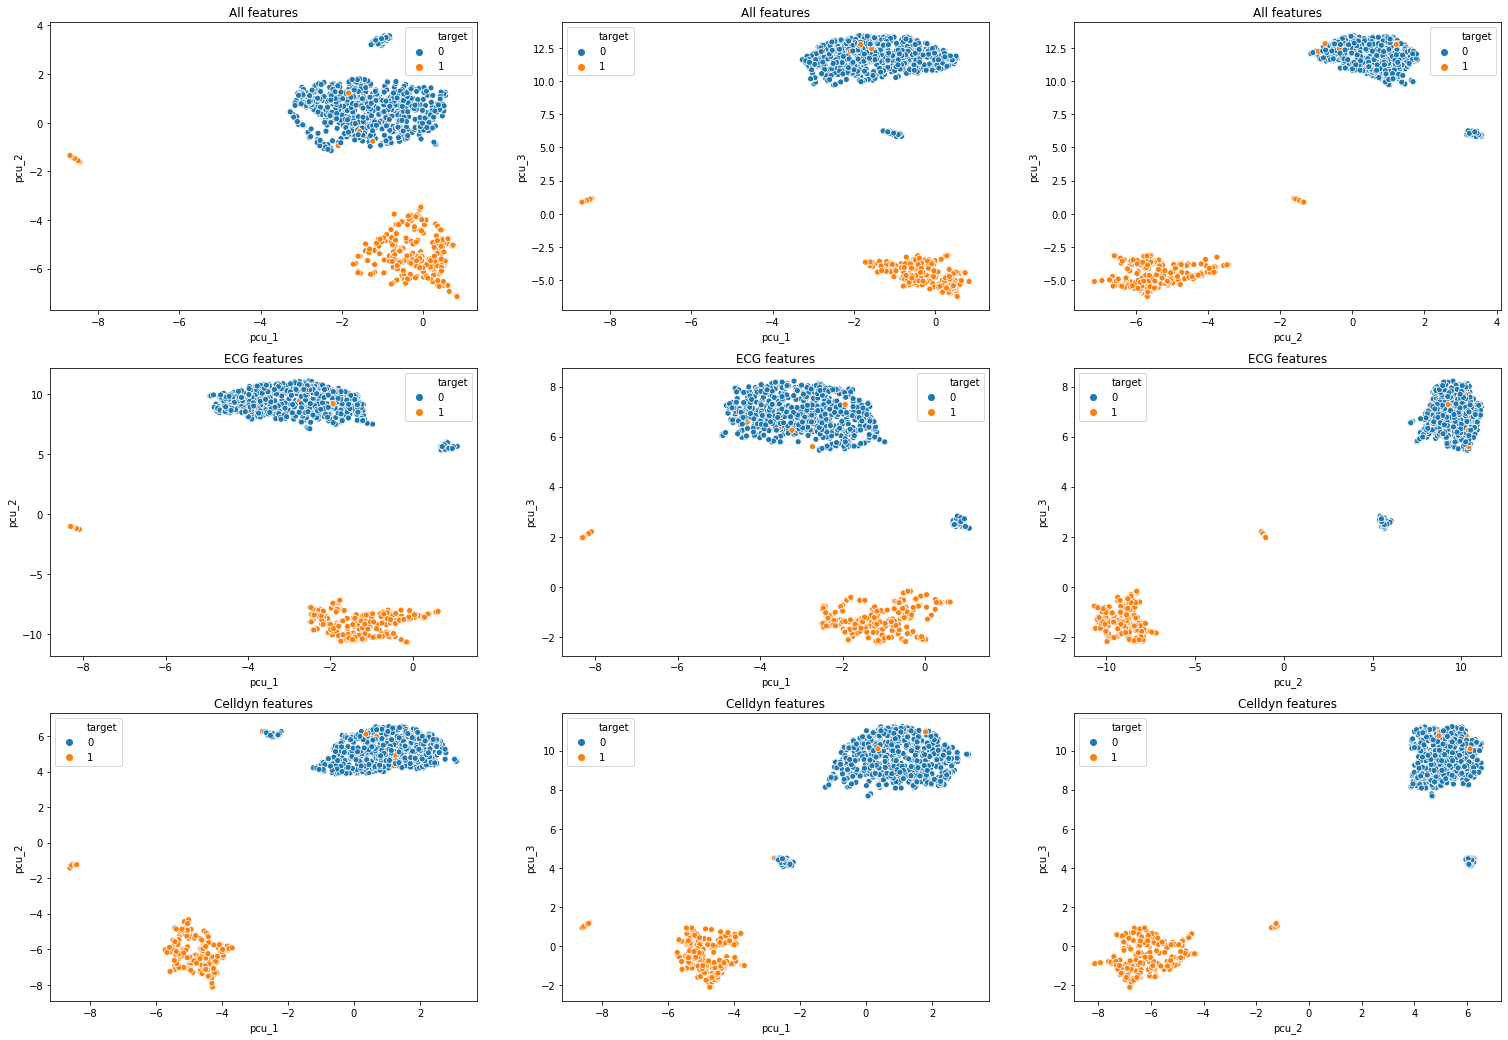

In [338]:
fig, ax = plt.subplots(ncols=3, nrows=3, figsize=(26,18))
sns.scatterplot(data=dat_viz['umap_all_sup'], x='pcu_1', y='pcu_2', hue=y, ax=ax[0,0])
sns.scatterplot(data=dat_viz['umap_all_sup'], x='pcu_1', y='pcu_3', hue=y, ax=ax[0,1])
sns.scatterplot(data=dat_viz['umap_all_sup'], x='pcu_2', y='pcu_3', hue=y, ax=ax[0,2])

sns.scatterplot(data=dat_viz['umap_ecg_sup'], x='pcu_1', y='pcu_2', hue=y, ax=ax[1,0])
sns.scatterplot(data=dat_viz['umap_ecg_sup'], x='pcu_1', y='pcu_3', hue=y, ax=ax[1,1])
sns.scatterplot(data=dat_viz['umap_ecg_sup'], x='pcu_2', y='pcu_3', hue=y, ax=ax[1,2])

sns.scatterplot(data=dat_viz['umap_celldyn_sup'], x='pcu_1', y='pcu_2', hue=y, ax=ax[2,0])
sns.scatterplot(data=dat_viz['umap_celldyn_sup'], x='pcu_1', y='pcu_3', hue=y, ax=ax[2,1])
sns.scatterplot(data=dat_viz['umap_celldyn_sup'], x='pcu_2', y='pcu_3', hue=y, ax=ax[2,2])

ax[0,0].set_title('All features')
ax[0,1].set_title('All features')
ax[0,2].set_title('All features')

ax[1,0].set_title('ECG features')
ax[1,1].set_title('ECG features')
ax[1,2].set_title('ECG features')

ax[2,0].set_title('Celldyn features')
ax[2,1].set_title('Celldyn features')
ax[2,2].set_title('Celldyn features')

Supervised UMAP clustering seems to be well able to separate the targets. 

## PLS

In [339]:
pls_all_sup = PLS(n_components=2)
dat_viz['pls_all_sup'] = pd.DataFrame(data=pls_all_sup.fit_transform(dat[var_cols], 
                                                             y=y)[0], 
                                   index=dat.index, columns=['pls_1', 'pls_2'])

pls_ecg_sup = PLS(n_components=2)
dat_viz['pls_ecg_sup'] = pd.DataFrame(data=pls_ecg_sup.fit_transform(dat[col_dict['ecg']], 
                                                             y=y)[0], 
                                   index=dat.index, columns=['pls_1', 'pls_2'])

pls_celldyn_sup = PLS(n_components=2)
dat_viz['pls_celldyn_sup'] = pd.DataFrame(data=pls_celldyn_sup.fit_transform(dat[col_dict['celldyn']], 
                                                             y=y)[0], 
                                   index=dat.index, columns=['pls_1', 'pls_2'])

Text(0.5, 1.0, 'Celldyn features')

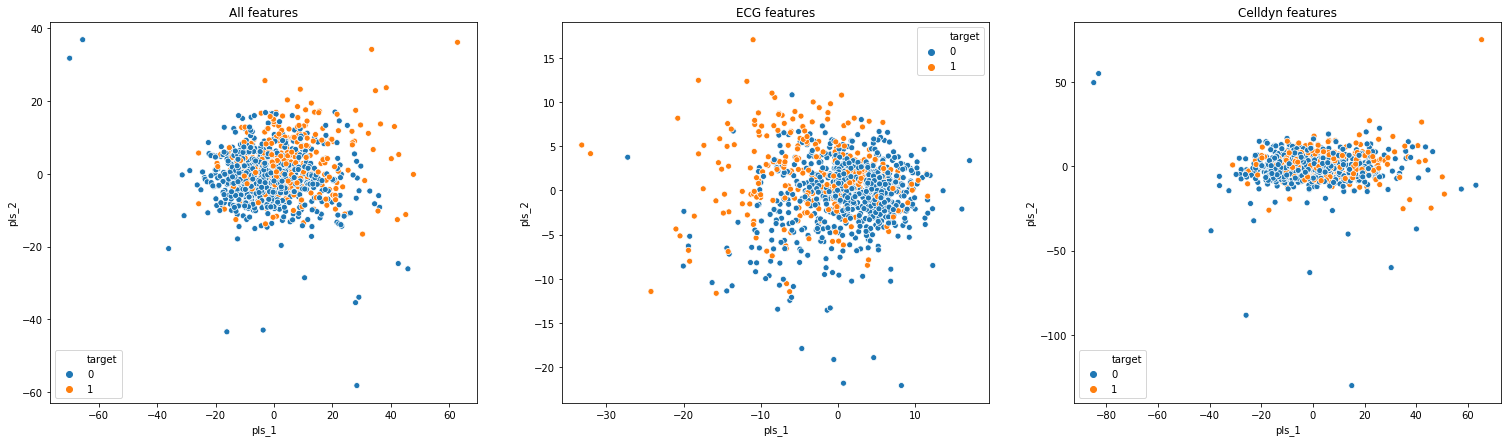

In [340]:
fig, ax = plt.subplots(ncols=3, figsize=(26,7))
sns.scatterplot(data=dat_viz['pls_all_sup'], x='pls_1', y='pls_2', hue=y, ax=ax[0])
sns.scatterplot(data=dat_viz['pls_ecg_sup'], x='pls_1', y='pls_2', hue=y, ax=ax[1])
sns.scatterplot(data=dat_viz['pls_celldyn_sup'], x='pls_1', y='pls_2', hue=y, ax=ax[2])

ax[0].set_title('All features')
ax[1].set_title('ECG features')
ax[2].set_title('Celldyn features')

## Cross-decomposition

PLS, CCA

# Linear separability using LDA

## ECG

c:\users\bes3\appdata\local\programs\python\python37\lib\site-packages\sklearn\discriminant_analysis.py:463: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(644, 2 - 1) = 1 components.
  ChangedBehaviorWarning)
c:\users\bes3\appdata\local\programs\python\python37\lib\site-packages\sklearn\discriminant_analysis.py:469: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)


Linear ECG. 	 negative accuracy:0.988599348534202, positive accuracy:0.7150259067357513


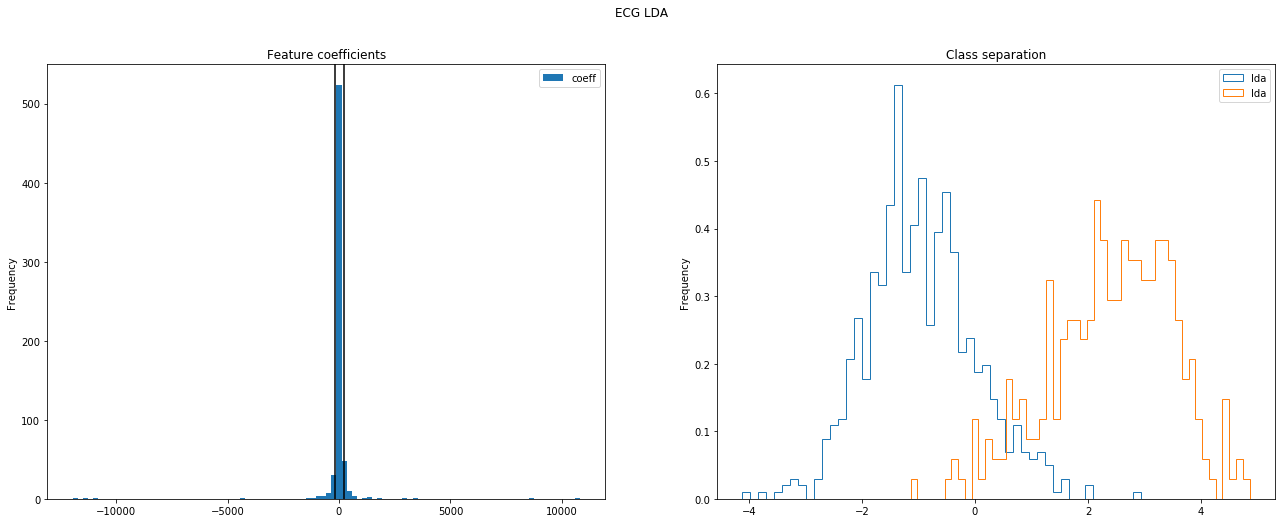

In [341]:
LDA_ecg = LDA(n_components=2)
lin_sep = pd.DataFrame(data=LDA_ecg.fit_transform(dat[col_dict['ecg']], y=y), index=dat.index, columns=['lda'])
coeff = pd.DataFrame(data=LDA_ecg.coef_[0], columns=['coeff'], index=col_dict['ecg'])

q95 = coeff.quantile(0.95)[0]
q05 = coeff.quantile(0.05)[0]

fig, ax = plt.subplots(ncols=2, figsize=(22,8))
coeff.plot.hist(bins=100, ax=ax[0])
ax[0].axvline(q95, color='black')
ax[0].axvline(q05, color='black')
lin_sep.loc[y==0].plot.hist(bins=50, histtype='step', density=True, ax=ax[1], label='0')
lin_sep.loc[y==1].plot.hist(bins=50, histtype='step', density=True, ax=ax[1], label='1')
ax[1].legend()
ax[0].set_title('Feature coefficients')
ax[1].set_title('Class separation')
plt.suptitle('ECG LDA')

# strong linear separators
strong_separators = dict()
strong_separators['lda'] = pd.concat([coeff.loc[coeff.coeff>q95], coeff.loc[coeff.coeff<q05]])

t = pd.DataFrame(lin_sep.lda)
t['target'] = y
thres=0

neg, pos = 1-t.loc[t.lda<thres].target.mean(), t.loc[t.lda>thres].target.mean()
print('Linear ECG. \t negative accuracy:{}, positive accuracy:{}'.format(neg, pos))

## Celldyn

c:\users\bes3\appdata\local\programs\python\python37\lib\site-packages\sklearn\discriminant_analysis.py:463: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(1592, 2 - 1) = 1 components.
  ChangedBehaviorWarning)
c:\users\bes3\appdata\local\programs\python\python37\lib\site-packages\sklearn\discriminant_analysis.py:469: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)


Linear CELLDYN. 	 negative accuracy:0.9786535303776683, positive accuracy:0.690537084398977


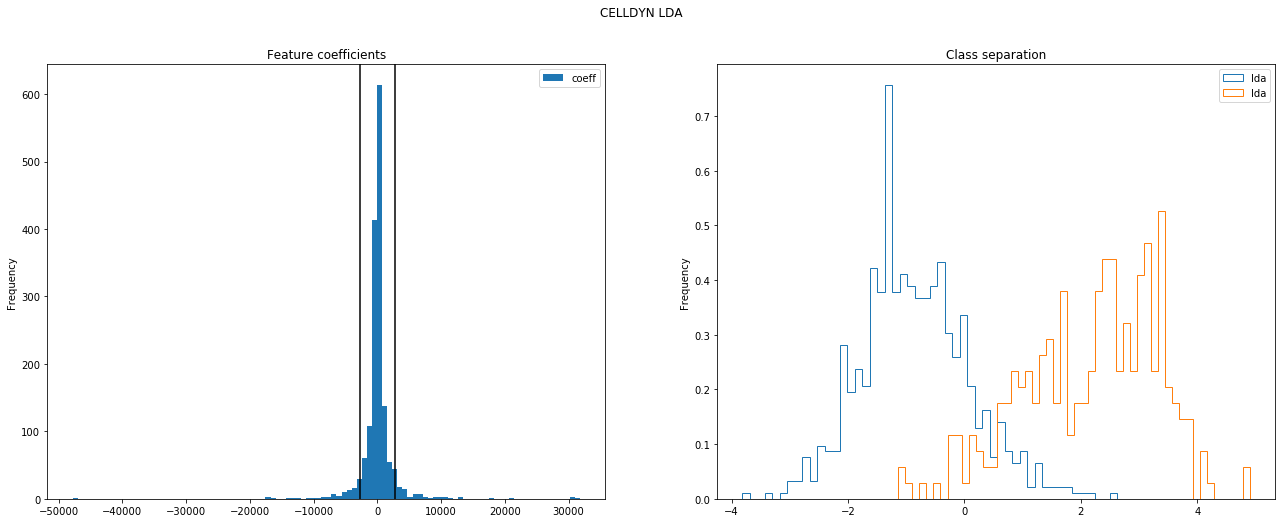

In [342]:
LDA_celldyn = LDA(n_components=2)
lin_sep = pd.DataFrame(data=LDA_celldyn.fit_transform(dat[col_dict['celldyn']], y=y), index=dat.index, columns=['lda'])
coeff = pd.DataFrame(data=LDA_celldyn.coef_[0], columns=['coeff'], index=col_dict['celldyn'])

q95 = coeff.quantile(0.95)[0]
q05 = coeff.quantile(0.05)[0]

fig, ax = plt.subplots(ncols=2, figsize=(22,8))
coeff.plot.hist(bins=100, ax=ax[0])
ax[0].axvline(q95, color='black')
ax[0].axvline(q05, color='black')
lin_sep.loc[y==0].plot.hist(bins=50, histtype='step', density=True, ax=ax[1], label='0')
lin_sep.loc[y==1].plot.hist(bins=50, histtype='step', density=True, ax=ax[1], label='1')
ax[1].legend()
ax[0].set_title('Feature coefficients')
ax[1].set_title('Class separation')
plt.suptitle('CELLDYN LDA')

# strong linear separators
strong_separators['lda'] = pd.concat([strong_separators['lda'], coeff.loc[coeff.coeff>q95], coeff.loc[coeff.coeff<q05]])

t = pd.DataFrame(lin_sep.lda)
t['target'] = y
thres=0
neg, pos = 1-t.loc[t.lda<thres].target.mean(), t.loc[t.lda>thres].target.mean()
print('Linear CELLDYN. \t negative accuracy:{}, positive accuracy:{}'.format(neg, pos))

## Other

c:\users\bes3\appdata\local\programs\python\python37\lib\site-packages\sklearn\discriminant_analysis.py:463: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(20, 2 - 1) = 1 components.
  ChangedBehaviorWarning)
c:\users\bes3\appdata\local\programs\python\python37\lib\site-packages\sklearn\discriminant_analysis.py:469: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)


Linear Other. 	 negative accuracy:0.8517241379310345, positive accuracy:0.46904761904761905


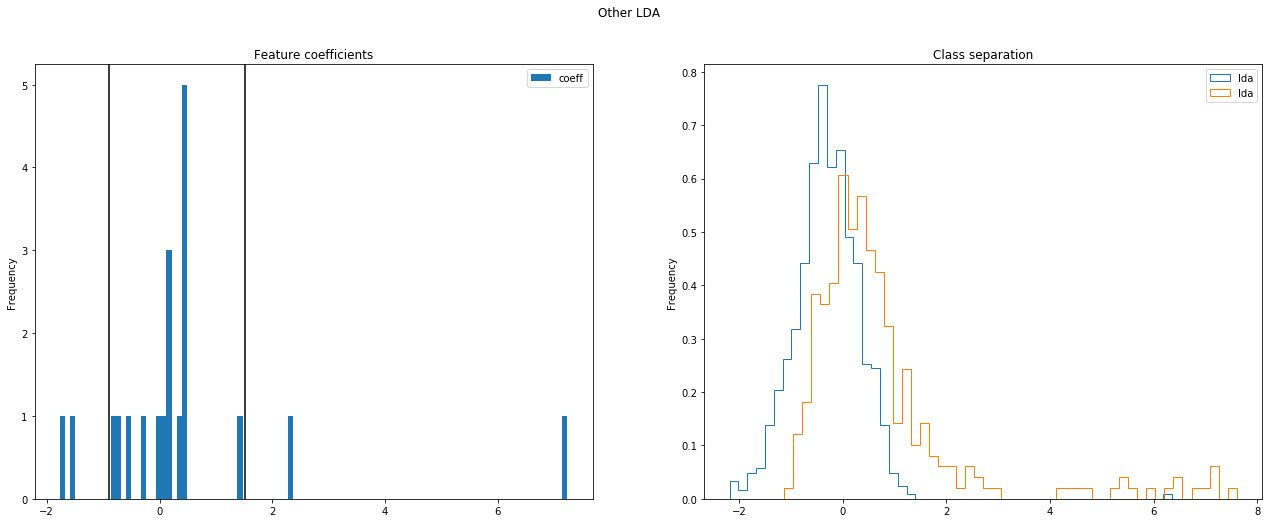

In [343]:
LDA_other = LDA(n_components=2)
lin_sep = pd.DataFrame(data=LDA_celldyn.fit_transform(dat[col_dict['other']], y=y), index=dat.index, columns=['lda'])
coeff = pd.DataFrame(data=LDA_celldyn.coef_[0], columns=['coeff'], index=col_dict['other'])

q90 = coeff.quantile(0.9)[0]
q10 = coeff.quantile(0.1)[0]

fig, ax = plt.subplots(ncols=2, figsize=(22,8))
coeff.plot.hist(bins=100, ax=ax[0])
ax[0].axvline(q90, color='black')
ax[0].axvline(q10, color='black')
lin_sep.loc[y==0].plot.hist(bins=50, histtype='step', density=True, ax=ax[1], label='0')
lin_sep.loc[y==1].plot.hist(bins=50, histtype='step', density=True, ax=ax[1], label='1')
ax[1].legend()
ax[0].set_title('Feature coefficients')
ax[1].set_title('Class separation')
plt.suptitle('Other LDA')

# strong linear separators
strong_separators['lda'] = pd.concat([strong_separators['lda'], coeff.loc[coeff.coeff>q90], coeff.loc[coeff.coeff<q10]])

t = pd.DataFrame(lin_sep.lda)
t['target'] = y
thres=0
neg, pos = 1-t.loc[t.lda<thres].target.mean(), t.loc[t.lda>thres].target.mean()
print('Linear Other. \t negative accuracy:{}, positive accuracy:{}'.format(neg, pos))

## Combined



c:\users\bes3\appdata\local\programs\python\python37\lib\site-packages\sklearn\discriminant_analysis.py:463: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(2256, 2 - 1) = 1 components.
  ChangedBehaviorWarning)
c:\users\bes3\appdata\local\programs\python\python37\lib\site-packages\sklearn\discriminant_analysis.py:469: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)


Linear all. 	 negative accuracy:1.0, positive accuracy:0.9826388888888888


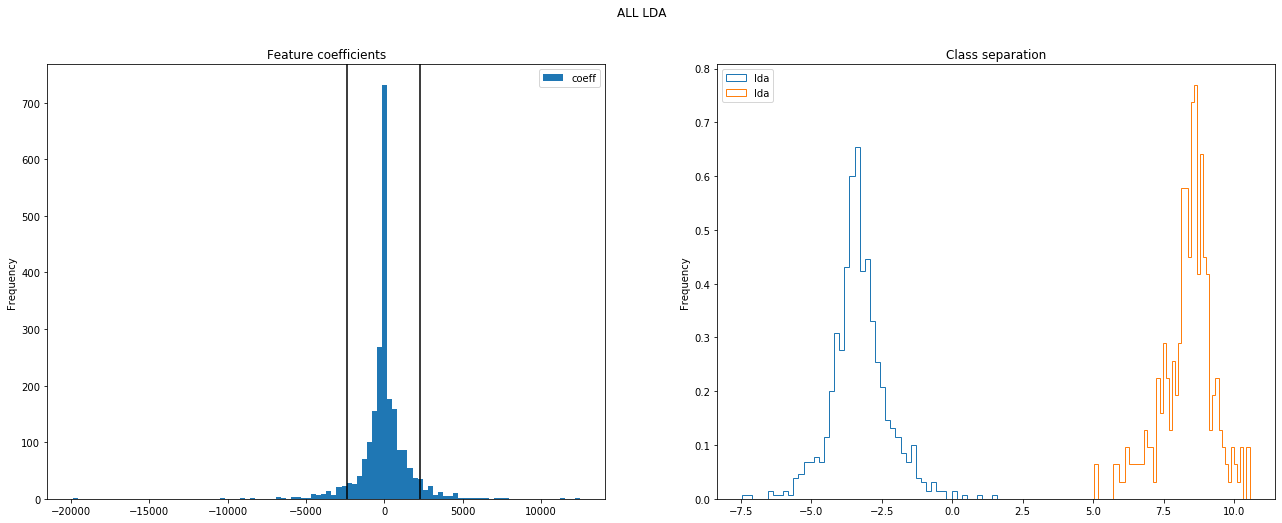

In [344]:
LDA_all = LDA(n_components=2)
var_cols = get_var_cols(col_dict)
lin_sep = pd.DataFrame(data=LDA_all.fit_transform(dat[var_cols], y=y), index=dat.index, columns=['lda'])
coeff = pd.DataFrame(data=LDA_all.coef_[0], columns=['coeff'], index=var_cols)

q95 = coeff.quantile(0.95)[0]
q05 = coeff.quantile(0.05)[0]

fig, ax = plt.subplots(ncols=2, figsize=(22,8))
coeff.plot.hist(bins=100, ax=ax[0])
ax[0].axvline(q95, color='black')
ax[0].axvline(q05, color='black')
lin_sep.loc[y==0].plot.hist(bins=50, histtype='step', density=True, ax=ax[1], label='0')
lin_sep.loc[y==1].plot.hist(bins=50, histtype='step', density=True, ax=ax[1], label='1')
ax[1].legend()
ax[0].set_title('Feature coefficients')
ax[1].set_title('Class separation')
plt.suptitle('ALL LDA')

# strong linear separators
strong_separators['lda'] = pd.concat([strong_separators['lda'], coeff.loc[coeff.coeff>q95], coeff.loc[coeff.coeff<q05]])

t = pd.DataFrame(lin_sep.lda)
t['target'] = y
thres=0
neg, pos = 1-t.loc[t.lda<thres].target.mean(), t.loc[t.lda>thres].target.mean()
print('Linear all. \t negative accuracy:{}, positive accuracy:{}'.format(neg, pos))

## HeartScore

c:\users\bes3\appdata\local\programs\python\python37\lib\site-packages\sklearn\discriminant_analysis.py:463: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(29, 2 - 1) = 1 components.
  ChangedBehaviorWarning)
c:\users\bes3\appdata\local\programs\python\python37\lib\site-packages\sklearn\discriminant_analysis.py:469: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)


Linear all. 	 negative accuracy:0.967551622418879, positive accuracy:0.8105590062111802


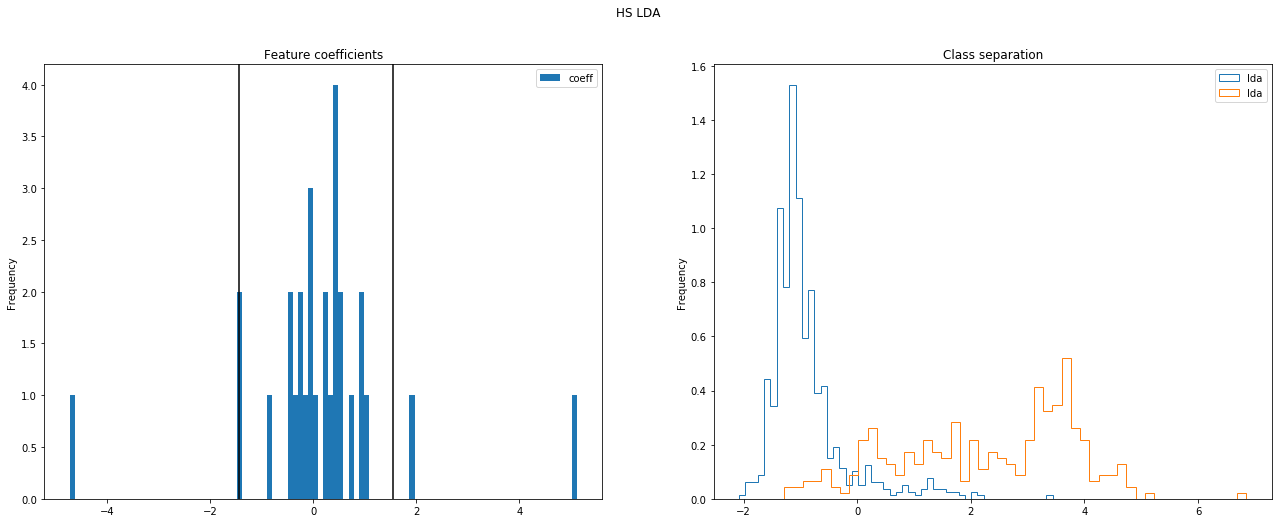

In [345]:
LDA_hs = LDA(n_components=2)
lin_sep = pd.DataFrame(data=LDA_hs.fit_transform(dat[hs_cols], y=y), index=dat.index, columns=['lda'])
coeff = pd.DataFrame(data=LDA_hs.coef_[0], columns=['coeff'], index=hs_cols)

q95 = coeff.quantile(0.95)[0]
q05 = coeff.quantile(0.05)[0]

fig, ax = plt.subplots(ncols=2, figsize=(22,8))
coeff.plot.hist(bins=100, ax=ax[0])
ax[0].axvline(q95, color='black')
ax[0].axvline(q05, color='black')
lin_sep.loc[y==0].plot.hist(bins=50, histtype='step', density=True, ax=ax[1], label='0')
lin_sep.loc[y==1].plot.hist(bins=50, histtype='step', density=True, ax=ax[1], label='1')
ax[1].legend()
ax[0].set_title('Feature coefficients')
ax[1].set_title('Class separation')
plt.suptitle('HS LDA')

# strong linear separators
strong_separators['lda'] = pd.concat([strong_separators['lda'], coeff.loc[coeff.coeff>q95], coeff.loc[coeff.coeff<q05]])

t = pd.DataFrame(lin_sep.lda)
t['target'] = y
thres=0
neg, pos = 1-t.loc[t.lda<thres].target.mean(), t.loc[t.lda>thres].target.mean()
print('Linear all. \t negative accuracy:{}, positive accuracy:{}'.format(neg, pos))

## Patient clustering

Using weighted correlation between the patient, where the weights are obtained from prior determined feature importances, say from LDA or PCA.

We can apply a pair-wise distance metric:
* KL-divergence
* cosine, euclidean etc.

Where it makes sense to include factor weights based on the separability.

Clustering options 
* Spectral clustering
* Louvain method (Fast community unfolding)
* Label propagation
* Walktrap community
* Edge betweenness community
* Leading eigenvector community
* Affinity propagation

In [346]:
# feature_weight


## Hausdorff distance between sample groups
See the [wiki](https://en.wikipedia.org/wiki/Hausdorff_distance).

SciPy has a function readily available, see [directed Hausdorff](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.directed_hausdorff.html)

One way to find patient clusters is to maximize the Hausdoff distance between patient groups.

# Supervised UMAP performance

In [347]:
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn import metrics
from sklearn.metrics import recall_score, make_scorer
import hdbscan

Text(0.5, 1.0, 'All features, test set')

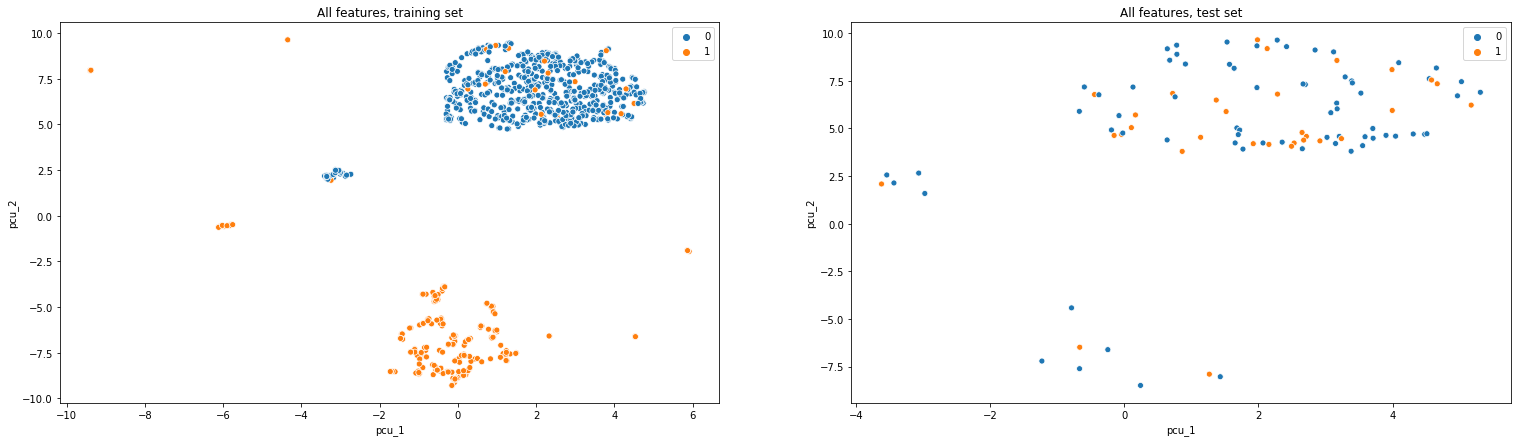

In [348]:
cols = get_var_cols(col_dict)

X_train, X_test, y_train, y_test = train_test_split(dat[cols], y, test_size=0.1, random_state=89)

if remove_outlying_samples_from_test:
    iso = IsolationForest(n_estimators=400, n_jobs=4)
    iso.fit(X_train)
    out_in = iso.predict(X_test)
    X_test = X_test[np.where(out_in==1),:]
    y_test = y_test[np.where(out_in==1)]
    

umap = UMAP(n_components=2, n_neighbors=7, min_dist=0.07)
umap.fit(X_train, y_train)

train_transform = pd.DataFrame(data=umap.transform(X_train), columns=['pcu_1', 'pcu_2'])
test_transform = pd.DataFrame(data=umap.transform(X_test), columns=['pcu_1', 'pcu_2'])

fig, ax = plt.subplots(ncols=2, figsize=(26,7))
sns.scatterplot(data=train_transform, x='pcu_1', y='pcu_2', hue=y_train.values, ax=ax[0])
sns.scatterplot(data=test_transform, x='pcu_1', y='pcu_2', hue=y_test.values, ax=ax[1])
ax[0].set_title('All features, training set')
ax[1].set_title('All features, test set')

In [349]:
cols = get_var_cols(col_dict)

clf = KNeighborsClassifier(n_neighbors=30, metric='minkowski', p=3)
X_train, X_test, y_train, y_test = train_test_split(dat[cols], y, test_size=0.05, random_state=None)
umap = UMAP(n_components=31, n_neighbors=30, min_dist=0.01)
umap.fit(X_train, y_train)

train_transform = umap.transform(X_train)
test_transform = umap.transform(X_test)

clf.fit(train_transform, y_train)
y_pred = clf.predict(test_transform)

metrics.accuracy_score(y_test, y_pred), metrics.f1_score(y_test, y_pred), metrics.roc_auc_score(y_test, y_pred)

(0.72, 0.0, 0.5)

In [350]:
scores = dict()
model = dict()

## LDA

In [351]:
clf = LDA()
scoring = {'auc': 'roc_auc', 
           'balanced_accuracy': 'balanced_accuracy',
           'f1_macro': 'f1_macro', 
           'prec_macro': 'precision_macro', 
           'rec_macro': make_scorer(recall_score, average='macro')}
scores['LDA'] = pd.DataFrame(cross_validate(clf, dat[cols].values, y.values, scoring=scoring, cv=10, return_train_score=True))
model['LDA'] = clf

## LR

In [352]:
clf = LogisticRegression(max_iter=500, penalty='l1', solver='liblinear')
scoring = {'auc': 'roc_auc', 
           'balanced_accuracy': 'balanced_accuracy',
           'f1_macro': 'f1_macro', 
           'prec_macro': 'precision_macro', 
           'rec_macro': make_scorer(recall_score, average='macro')}
scores['LR'] = pd.DataFrame(cross_validate(clf, dat[cols].values, y.values, scoring=scoring, cv=10, return_train_score=True))
model['LR'] = clf

## RF

In [353]:
clf = RandomForestClassifier(n_estimators=200)
scoring = {'auc': 'roc_auc', 
           'balanced_accuracy': 'balanced_accuracy',
           'f1_macro': 'f1_macro', 
           'prec_macro': 'precision_macro', 
           'rec_macro': make_scorer(recall_score, average='macro')}
scores['RF'] = pd.DataFrame(cross_validate(clf, dat[cols].values, y.values, scoring=scoring, cv=10, return_train_score=True))
model['RF'] = clf

## nuSVM

In [354]:
clf = NuSVC(nu=0.5)
scoring = {'auc': 'roc_auc', 
           'balanced_accuracy': 'balanced_accuracy',
           'f1_macro': 'f1_macro', 
           'prec_macro': 'precision_macro', 
           'rec_macro': make_scorer(recall_score, average='macro')}
scores['SVC'] = pd.DataFrame(cross_validate(clf, dat[cols].values, y.values, scoring=scoring, cv=10, return_train_score=True))
model['SVC'] = clf

## MLP

In [355]:
clf = MLPClassifier(hidden_layer_sizes=(100,50,25), max_iter=200, learning_rate_init=0.005, learning_rate='adaptive')
scoring = {'auc': 'roc_auc', 
           'balanced_accuracy': 'balanced_accuracy',
           'f1_macro': 'f1_macro', 
           'prec_macro': 'precision_macro', 
           'rec_macro': make_scorer(recall_score, average='macro')}
scores['MLP'] = pd.DataFrame(cross_validate(clf, dat[cols].values, y.values, scoring=scoring, cv=10, return_train_score=True))
model['MLP'] = clf

## Ensembling
We combine: RF+nuSVM+LR+LDA.

In [356]:
clfs = [('RF', RandomForestClassifier(n_estimators=200)),
        ('nuSVC', NuSVC(nu=0.5, probability=True)),
        ('LR', LogisticRegression(max_iter=500, solver='liblinear')),
        ('MLP', MLPClassifier(hidden_layer_sizes=(100,50,50), 
                              max_iter=200, learning_rate_init=0.005, learning_rate='adaptive'))]


clf = VotingClassifier(clfs, voting='soft', weights=[10, 5, 7, 3])

scoring = {'auc': 'roc_auc', 
           'balanced_accuracy': 'balanced_accuracy',
           'f1_macro': 'f1_macro', 
           'prec_macro': 'precision_macro', 
           'rec_macro': make_scorer(recall_score, average='macro')}
scores['ensemble_vote'] = pd.DataFrame(cross_validate(clf, dat[cols].values, y.values, 
                                                      scoring=scoring, 
                                                      cv=10, return_train_score=True))
model['ensemble_vote'] = clf

In [357]:
clf = BaggingClassifier(base_estimator=LogisticRegression(max_iter=500, solver='liblinear'), n_estimators=5)

scoring = {'auc': 'roc_auc', 
           'balanced_accuracy': 'balanced_accuracy',
           'f1_macro': 'f1_macro', 
           'prec_macro': 'precision_macro', 
           'rec_macro': make_scorer(recall_score, average='macro')}
scores['ensemble_bag'] = pd.DataFrame(cross_validate(clf, dat[cols].values, y.values, 
                                                    scoring=scoring, 
                                                     cv=10, return_train_score=True))
model['ensemble_bag'] = clf

In [366]:
# HS
clfs = [('RF', RandomForestClassifier(n_estimators=50)),
        ('nuSVC', NuSVC(nu=0.5, probability=True)),
        ('LR', LogisticRegression(max_iter=500, solver='liblinear')),
        ('MLP', MLPClassifier(hidden_layer_sizes=(40,30,20), 
                              max_iter=200, learning_rate_init=0.002, learning_rate='adaptive'))]


clf = VotingClassifier(clfs, voting='soft', weights=[10, 5, 7, 3])

scoring = {'auc': 'roc_auc', 
           'balanced_accuracy': 'balanced_accuracy',
           'f1_macro': 'f1_macro', 
           'prec_macro': 'precision_macro', 
           'rec_macro': make_scorer(recall_score, average='macro')}
scores['ensemble_vote_hs'] = pd.DataFrame(cross_validate(clf, dat[hs_cols].values, y.values, 
                                                      scoring=scoring, 
                                                      cv=10, return_train_score=True))
model['ensemble_vote_hs'] = clf

In [368]:
# celldyn
clfs = [('RF', RandomForestClassifier(n_estimators=200)),
        ('nuSVC', NuSVC(nu=0.5, probability=True)),
        ('LR', LogisticRegression(max_iter=500, solver='liblinear')),
        ('MLP', MLPClassifier(hidden_layer_sizes=(100,50,50), 
                              max_iter=200, learning_rate_init=0.005, learning_rate='adaptive'))]


clf = VotingClassifier(clfs, voting='soft', weights=[10, 5, 7, 3])

scoring = {'auc': 'roc_auc', 
           'balanced_accuracy': 'balanced_accuracy',
           'f1_macro': 'f1_macro', 
           'prec_macro': 'precision_macro', 
           'rec_macro': make_scorer(recall_score, average='macro')}
scores['ensemble_vote_celldyn'] = pd.DataFrame(cross_validate(clf, dat[col_dict['celldyn']].values, y.values, 
                                                      scoring=scoring, 
                                                      cv=10, return_train_score=True))
model['ensemble_vote_celldyn'] = clf

c:\users\bes3\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\bes3\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\bes3\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [369]:
# celldyn+age+sex+BMI+troponine
clfs = [('RF', RandomForestClassifier(n_estimators=200)),
        ('nuSVC', NuSVC(nu=0.5, probability=True)),
        ('LR', LogisticRegression(max_iter=500, solver='liblinear')),
        ('MLP', MLPClassifier(hidden_layer_sizes=(100,50,50), 
                              max_iter=200, learning_rate_init=0.005, learning_rate='adaptive'))]


clf = VotingClassifier(clfs, voting='soft', weights=[10, 5, 7, 3])

ex_feat = ['AGE', 'gender', 'BMI', 'tn_admission']
scoring = {'auc': 'roc_auc', 
           'balanced_accuracy': 'balanced_accuracy',
           'f1_macro': 'f1_macro', 
           'prec_macro': 'precision_macro', 
           'rec_macro': make_scorer(recall_score, average='macro')}
scores['ensemble_vote_celldyn_plusMeta'] = pd.DataFrame(cross_validate(clf, dat[col_dict['celldyn']+ex_feat].values, y.values, 
                                                      scoring=scoring, 
                                                      cv=10, return_train_score=True))
model['ensemble_vote_celldyn_plusMeta'] = clf

In [372]:
# celldyn+age+sex+BMI+troponine+ECG
clfs = [('RF', RandomForestClassifier(n_estimators=400)),
        ('nuSVC', NuSVC(nu=0.5, probability=True)),
        ('LR', LogisticRegression(max_iter=500, solver='liblinear')),
        ('MLP', MLPClassifier(hidden_layer_sizes=(100,50,50), 
                              max_iter=200, learning_rate_init=0.005, learning_rate='adaptive'))]


clf = VotingClassifier(clfs, voting='soft', weights=[10, 5, 7, 3])

ex_feat = ['AGE', 'gender', 'BMI', 'tn_admission']+col_dict['ecg']
scoring = {'auc': 'roc_auc', 
           'balanced_accuracy': 'balanced_accuracy',
           'f1_macro': 'f1_macro', 
           'prec_macro': 'precision_macro', 
           'rec_macro': make_scorer(recall_score, average='macro')}
scores['ensemble_vote_celldyn_plusMeta_plusECG'] = pd.DataFrame(cross_validate(clf, dat[col_dict['celldyn']+ex_feat].values, y.values, 
                                                      scoring=scoring, 
                                                      cv=10, return_train_score=True))
model['ensemble_vote_celldyn_plusMeta_plusECG'] = clf

## Supervised SOM performance

SuSi: [paper](https://arxiv.org/abs/1903.11114), [code](https://github.com/felixriese/susi)

-- SOM fitted --


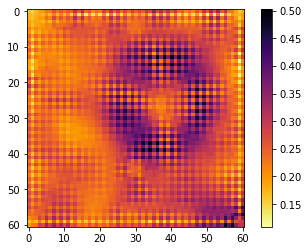

In [358]:
import susi

cols = get_var_cols(col_dict)
cclf = susi.SOMClustering(n_rows=31, n_columns=31)
cclf.fit(dat[cols].values)
print("-- SOM fitted --")

u_matrix = cclf.get_u_matrix()
plt.imshow(np.squeeze(u_matrix), cmap="inferno_r")
plt.colorbar()
plt.show()

In [359]:
clf = susi.SOMClassifier(n_rows=31,
                         n_columns=31,
                         n_iter_unsupervised=5000,
                         n_iter_supervised=5000,
                         random_state=0)
clf.fit(X_train, y_train.astype(np.int32))

y_pred = clf.predict(X_test)
metrics.accuracy_score(y_test, y_pred), metrics.f1_score(y_test, y_pred), metrics.roc_auc_score(y_test, y_pred)

(0.42, 0.32558139534883723, 0.4444444444444444)

### Learning Vector Quantization

In [360]:
from neupy import algorithms

X_train, X_test, y_train, y_test = train_test_split(dat[cols], y, test_size=0.05, random_state=None)

# reduce
#red = UMAP(n_components=31, n_neighbors=30, min_dist=0.01)
red = PCA(n_components=30)
red.fit(X_train)
X_train = red.transform(X_train)
X_test = red.transform(X_test)


clf = algorithms.LVQ(n_inputs=X_train.shape[1], n_classes=2, n_subclasses=11, shuffle_data=False)
clf.train(X_train, y_train, epochs=500)
y_pred = clf.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred), metrics.f1_score(y_test, y_pred), metrics.roc_auc_score(y_test, y_pred))

clf = algorithms.LVQ21(n_inputs=X_train.shape[1], n_classes=2, n_subclasses=11, shuffle_data=False)
clf.train(X_train, y_train, epochs=500)
y_pred = clf.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred), metrics.f1_score(y_test, y_pred), metrics.roc_auc_score(y_test, y_pred))

clf = algorithms.LVQ3(n_inputs=X_train.shape[1], n_classes=2, n_subclasses=11, shuffle_data=False)
clf.train(X_train, y_train, epochs=500)
y_pred = clf.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred), metrics.f1_score(y_test, y_pred), metrics.roc_auc_score(y_test, y_pred))

0.62 0.29629629629629634 0.55


0.6 0.0 0.5


c:\users\bes3\appdata\local\programs\python\python37\lib\site-packages\numpy\linalg\linalg.py:2513: RuntimeWarning: overflow encountered in reduce
  return sqrt(add.reduce(s, axis=axis, keepdims=keepdims))
c:\users\bes3\appdata\local\programs\python\python37\lib\site-packages\numpy\linalg\linalg.py:2512: RuntimeWarning: overflow encountered in multiply
  s = (x.conj() * x).real
c:\users\bes3\appdata\local\programs\python\python37\lib\site-packages\neupy\algorithms\competitive\lvq.py:564: RuntimeWarning: overflow encountered in subtract
  weight[top1_subclass, :] -= step * top1_weight_update


0.6 0.0 0.5
